
## *Insight into Seattle Airbnb listings*

## Overview

The project illustrates a structured approach to planning a data mining project via the CRISP-DM methodology.The cross-industry process for data mining streamlines the process of Data Science /Machine Learning project. The analysis though the phases of the framework will unravel insights into Airbnb Seattle dataset.

Stellar growth of Airbnb has disrupted the lodging industry as the leading online marketplace and hospitality service brokerage company.From humble beginings of renting their loft to pay for their rent to a billion dollar company providing customers, unique and personalised travelling experiences of  'living like a local', Airbnb sure has given hotels, a run for their money. The current analysis uses [Seattle Airbnb dataset](https://www.kaggle.com/Airbnb/seattle/data) to understand the trends and factors influencing rental prices.Note this will be an elementary level analysis. *The project's scope is limited to exploratory data analysis and modelling data to predict the pricing of the listings.The futurework involving natural language processing and image processing of the data  will be done in stages.*

## Business Understanding

In order to rent out the property or monetise any extra space, the property needs to be advertised on the Airbnb website by the owners.The listing data from the owners or the hosts captures  a gamut of info about the owner,features of the property(s),availability for different time frames and their pricing,reviews,nearby places to visit,etc. Each listing's availability for 365 days with their pricing is captured in calender data.We shall analyse listings and calender data to address the below objectives. 

1. Listings growth over the years in various neighborhoods of Seattle.
2. Concentration of multiple listings in the neighbourhood groups and their impact.
3. Identify neighbourhood groups :
    a. Favoured by the guests.
    b. Distinct neighborhoods in terms of pricing and ratings. 
    
3. What times of the year,do we see availability at best pricings.
4. Features that influence the property pricing.


The analysis here looks at prediction of the listing's price to determine the price for new listings.

## Data Understanding

 [Seattle Airbnb dataset](https://www.kaggle.com/Airbnb/seattle/data) utilizes listings data scraped as of date 2016-01-04 and calender info for the period  2016-01-04 : 2017-01-02.  The .csv files that will serve as the basis of our analysis :listings and calendar. We shall begin our data understanding by describing,assessing and verifying the data for quality.As we progress in our analysis, observations and takeaway points(s) will be noted.

In [96]:
#Load the required libraries
import pandas as pd
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns

matplotlib.style.use('ggplot')

#!pip install pycodestyle flake8 pycodestyle_magic
%load_ext pycodestyle_magic
#%%pycodestyle

import warnings
warnings.filterwarnings("ignore")

#from IPython.display import display
#from time import time
#conda install -c conda-forge folium
#import folium
#from folium import plugins
#import geopandas as gpd
#pd.options.display.max_colwidth =150

import cufflinks as cf

import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

import numpy as np; np.random.seed(sum(map(ord, 'calmap')))
import calmap
import itertools

from sklearn.model_selection  import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import median_absolute_error,mean_absolute_error,mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt


from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from sklearn.linear_model import Lasso,LinearRegression,LassoCV
from sklearn import metrics
from xgboost import plot_importance

The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic


In [2]:
# Read in the data to a dataframe and view few records.
listings = pd.read_csv('listings.csv')
listings.head(1)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07


In [3]:
calender = pd.read_csv('calendar.csv', parse_dates=True)
calender.head(2)

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00


In [15]:
# Get the row and column count,columns and their datatypes and presence of null values.
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
id                                  3818 non-null int64
listing_url                         3818 non-null object
scrape_id                           3818 non-null int64
last_scraped                        3818 non-null object
name                                3818 non-null object
summary                             3641 non-null object
space                               3249 non-null object
description                         3818 non-null object
experiences_offered                 3818 non-null object
neighborhood_overview               2786 non-null object
notes                               2212 non-null object
transit                             2884 non-null object
thumbnail_url                       3498 non-null object
medium_url                          3498 non-null object
picture_url                         3818 non-null object
xl_picture_url                      3498

** The listings datset will be investigated for  numeric and categorical variables separately. Consider only the numeric columns for now -**

In [16]:
num_listings = listings.select_dtypes(include=['int64', 'float64'])
num_listings.columns

Index(['id', 'scrape_id', 'host_id', 'host_listings_count',
       'host_total_listings_count', 'latitude', 'longitude', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'square_feet', 'guests_included',
       'minimum_nights', 'maximum_nights', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'license', 'calculated_host_listings_count',
       'reviews_per_month'],
      dtype='object')

Lets look at how the numeric columns affect price, the target variable per one of our goals. Price is of object dtype and this needs to be converted to numeric and appended to numeric data subset.

In [17]:
# We shall add price column,price is shown as object type.
obj_listings = listings.select_dtypes(include=['object'])

In [18]:
def str_conv(col):
    '''
    Remove special characters and retain the numeric component only.
    
    Parameters : 
    col(dataframe column or a series object) with special characters.
    
    Returns : 
    col(dataframe column or a series) object post conversion.
    '''
    
    col = col.str.replace('$', '').str.replace(',', '').astype('float')
    return col

In [19]:
obj_listings['price'] = str_conv(obj_listings['price'])
num_listings['price'] = obj_listings['price']  # Add the price variable to numeric listing

In [20]:
# Add in the unique id,to be used for merge later
obj_listings['id'] = num_listings['id']

In [21]:
# Check for null values
num_listings['price'].isnull().sum()

0

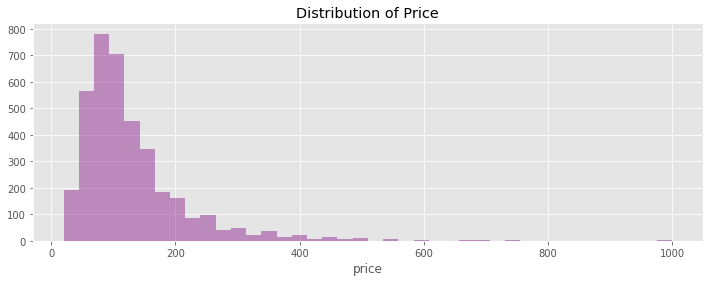

count    3818.000000
mean      127.976166
std        90.250022
min        20.000000
25%        75.000000
50%       100.000000
75%       150.000000
max      1000.000000
Name: price, dtype: float64

In [97]:
# Understand distribution of price
fig, axes = plt.subplots(figsize=(12, 4))
sns.distplot(num_listings['price'], bins=40, kde=False, color='purple');
plt.title('Distribution of Price');
plt.show()

(num_listings.price.describe())

The distribution is highly right skewed.Majority of the rental property price is below `$150`  and median rental price is `$100` . There are also few highly priced properties with values greater than `$600`    dragging the mean towards the right.

**Check for missing values in numeric columns**

In [94]:
# proportion of missing values >80% for columns will be dropped.
((num_listings.isnull().sum()/num_listings.shape[0]) * 100).iplot(kind='bar',title='Proportion of missing values',
                                                                  dimensions=(1116, 630),
                                                                 xTitle='Numeric columns from listings', yTitle='Proportion of missing values')

More than 90% of data is missing in the columns -square_feet and license and can drop these two columns.
Bunch of columns related to reviews are missing proportionally.

In [130]:
# scrape_id  is the date the data was scraped and can be dropped as there is no further value addition for our analysis.
num_listings['scrape_id'].unique()

array([20160104002432], dtype=int64)

**Host and Listings count **

In [124]:
host_listings = num_listings[['id', 'host_id', 'host_listings_count', 'host_total_listings_count',
                            'calculated_host_listings_count']]
host_listings.head(7)

,id,host_id,host_listings_count,host_total_listings_count,calculated_host_listings_count
0,241032,956883,3.0,3.0,2
1,953595,5177328,6.0,6.0,6
2,3308979,16708587,2.0,2.0,2
3,7421966,9851441,1.0,1.0,1
4,278830,1452570,2.0,2.0,1
5,5956968,326758,1.0,1.0,1
6,1909058,2497928,1.0,1.0,1


In [125]:
# Random check on the host ids

host_listings[host_listings.host_id.isin([956883,5177328,1452570])].sort_values(by='host_id',ascending=False)

,id,host_id,host_listings_count,host_total_listings_count,calculated_host_listings_count
1,953595,5177328,6.0,6.0,6
9,2493658,5177328,6.0,6.0,6
30,2481869,5177328,6.0,6.0,6
1919,6780615,5177328,6.0,6.0,6
3448,3382533,5177328,6.0,6.0,6
3451,7227464,5177328,6.0,6.0,6
4,278830,1452570,2.0,2.0,1
1920,2586642,1452570,2.0,2.0,1
0,241032,956883,3.0,3.0,2
451,9167786,956883,3.0,3.0,2


We see that host_total_listings_count and calculated_host_listings_count donot tally for host_ids- 1452570 ,956883. host_id and id combination is unique, in that host_id is the listing from a host with unique id. 'id's are listing ids of a specific host.Above we see host with multiple listings.

In [133]:
host_listings[host_listings['host_total_listings_count']!=host_listings['calculated_host_listings_count']].sort_values(by='host_id').tail(10)

,id,host_id,host_listings_count,host_total_listings_count,calculated_host_listings_count
90,9098059,43954674,3.0,3.0,2
2975,9429399,45092482,3.0,3.0,1
2990,8567933,45092482,3.0,3.0,1
3706,9513636,48273510,3.0,3.0,1
3678,9511777,48273510,3.0,3.0,1
194,9367465,48604323,2.0,2.0,1
154,9368517,48604323,2.0,2.0,1
1476,9900303,50913131,4.0,4.0,2
1485,9939025,50913131,4.0,4.0,2
2955,10339144,53208610,2.0,2.0,1


Further we see that number of entries for host_id doesnot tally with host_total_listings_count and calculated_host_listings_count.This is not going to aid us in analysis.We shall drop the three listing count columns and instead add one column `listings_count` based on the number of unique host_ids count.


**Correlation between numeric features and price**

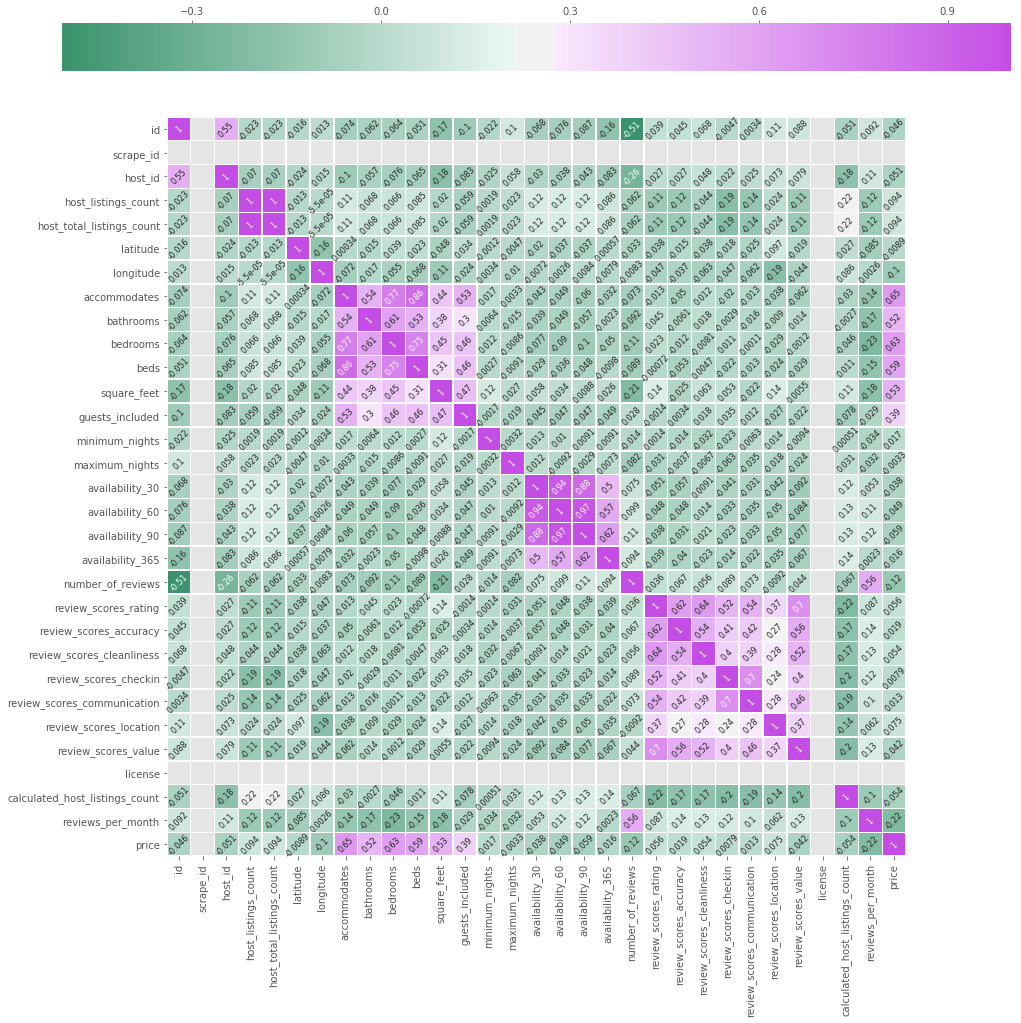

In [98]:
fig,axes=plt.subplots(1,1,figsize=(17,17))
cmap = sns.diverging_palette(150, 295, s=80, l=55, n=9, as_cmap=True)
#sns.set(font_scale=1.1)
sns.heatmap(num_listings.corr(),cmap=cmap,annot=True,linewidths=0.5, annot_kws={"size": 8,'rotation':45},square=True,cbar_kws = dict(use_gridspec=False,location="top") );

Price is positively correlated with accommodates,bathrooms,bedrooms,beds,square feet and guests_included and notable negative correlation with number of reviews and reviews per month.


**Check for missing values in object dtype columns**

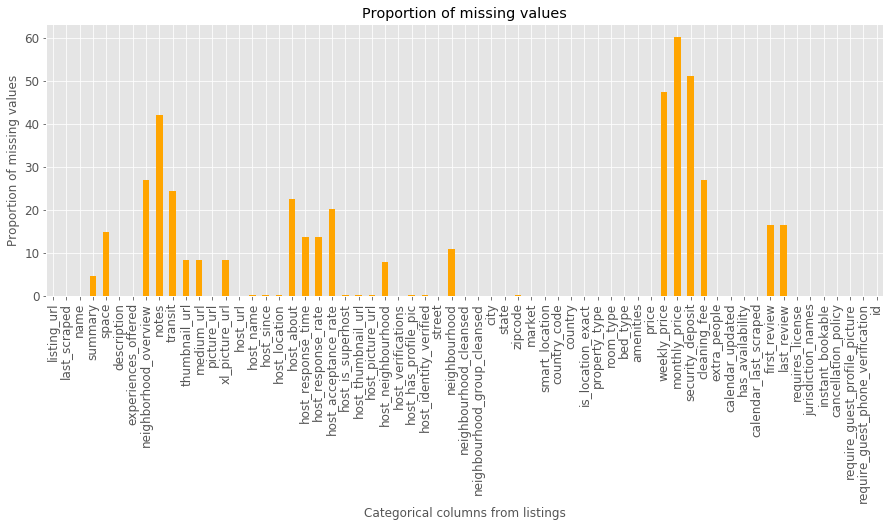

In [135]:
# Proportion of missing values greater than 40% in object listings

fig,axes=plt.subplots(1,1,figsize=(15,5))
(obj_listings.isnull().sum()/obj_listings.shape[0]*100).plot(kind='bar',color='orange');
plt.xticks(fontsize=12),plt.yticks(fontsize=12);
plt.title('Proportion of missing values')
plt.xlabel('Categorical columns from listings')
plt.ylabel('Proportion of missing values');

Proportion of values of missing > 40% --notes,weekly_price,monthly_price,security_deposit.
Columns with greater than 40%  missing values will be dropped along with columns that will not be part of the analysis.

In [35]:
# Calender data

calender.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
listing_id    1393570 non-null int64
date          1393570 non-null object
available     1393570 non-null object
price         934542 non-null object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


In [136]:
# Shape of the listings

listings.shape

(3818, 92)

Listings and calender row count is unequal.Let us understand more.

In [37]:
calender_cnt=calender['listing_id'].value_counts().to_frame().reset_index().rename(columns={'index':'listing_id','listing_id':'listing_cnt_avail'})
calender_cnt.listing_cnt_avail.unique()

array([365], dtype=int64)

In [38]:
# Availability of the listing id 

calender_cnt.head()

,listing_id,listing_cnt_avail
0,6752031,365
1,7404370,365
2,1259305,365
3,4672934,365
4,10310373,365


In [39]:
print(calender_cnt.shape)

(3818, 2)


We see that calender df provides details of the availabilty of each listings for the entire 365 days.

### Data Preparation

We had found that the listings count related columns donot tally.Hence we shall delete the following columns - calculated_host_listings_count,total_host_listings_count and host_listings_count. A new column, `listings_count` will be created.

In [137]:
host_listings[host_listings['host_total_listings_count'] != host_listings['calculated_host_listings_count']].sort_values(by='host_id').tail(10)

,id,host_id,host_listings_count,host_total_listings_count,calculated_host_listings_count
90,9098059,43954674,3.0,3.0,2
2975,9429399,45092482,3.0,3.0,1
2990,8567933,45092482,3.0,3.0,1
3706,9513636,48273510,3.0,3.0,1
3678,9511777,48273510,3.0,3.0,1
194,9367465,48604323,2.0,2.0,1
154,9368517,48604323,2.0,2.0,1
1476,9900303,50913131,4.0,4.0,2
1485,9939025,50913131,4.0,4.0,2
2955,10339144,53208610,2.0,2.0,1


In [126]:
# Get the unique value counts of the host_id.This will give us the multiple listings from a host. 
host_listings_count = num_listings['host_id'].value_counts().to_frame(name=('listings_count')).reset_index().rename(columns={'index':'host_id'})
host_listings_count.head(2)

,host_id,listings_count
0,8534462,46
1,4962900,39


In [127]:
# Random check on a host id
num_listings[num_listings.host_id==956883]

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,calculated_host_listings_count,reviews_per_month,price
0,241032,20160104002432,956883,3.0,3.0,47.636289,-122.371025,4,1.0,1.0,...,10.0,10.0,10.0,10.0,9.0,10.0,NaN,2,4.07,85.0
451,9167786,20160104002432,956883,3.0,3.0,47.642358,-122.374047,2,1.0,1.0,...,8.0,10.0,10.0,10.0,10.0,8.0,NaN,2,0.65,50.0
485,241016,20160104002432,956883,3.0,3.0,47.643286,-122.375819,4,1.0,2.0,...,10.0,9.0,10.0,10.0,9.0,9.0,NaN,2,0.67,115.0


In [128]:
# Merge the host_listings_count to host_listings
host_listings = host_listings.merge(host_listings_count, on='host_id')

In [129]:
# Cross  check the values
host_listings[host_listings.host_id.isin([48273510,50913131])].sort_values(by='host_id', ascending=False)

,id,host_id,host_listings_count,host_total_listings_count,calculated_host_listings_count,listings_count
1687,9900303,50913131,4.0,4.0,2,2
1688,9939025,50913131,4.0,4.0,2,2
3705,9511777,48273510,3.0,3.0,1,2
3706,9513636,48273510,3.0,3.0,1,2


In [130]:
# Drop the related host_listings_count columns from num_listings
num_listings.drop(['host_listings_count', 'host_total_listings_count','calculated_host_listings_count'],axis=1,inplace=True)

# Add new feature listings count  to the num_listings df
num_listings = num_listings.merge(host_listings_count,on='host_id')

In [131]:
# Random check on a host_id
num_listings[num_listings.host_id==956883]

,id,scrape_id,host_id,latitude,longitude,accommodates,bathrooms,bedrooms,beds,square_feet,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,reviews_per_month,price,listings_count
0,241032,20160104002432,956883,47.636289,-122.371025,4,1.0,1.0,1.0,NaN,...,10.0,10.0,10.0,10.0,9.0,10.0,NaN,4.07,85.0,3
1,9167786,20160104002432,956883,47.642358,-122.374047,2,1.0,1.0,1.0,NaN,...,8.0,10.0,10.0,10.0,10.0,8.0,NaN,0.65,50.0,3
2,241016,20160104002432,956883,47.643286,-122.375819,4,1.0,2.0,3.0,NaN,...,10.0,9.0,10.0,10.0,9.0,9.0,NaN,0.67,115.0,3


**How does Price relate to review related columns and listings_count?**

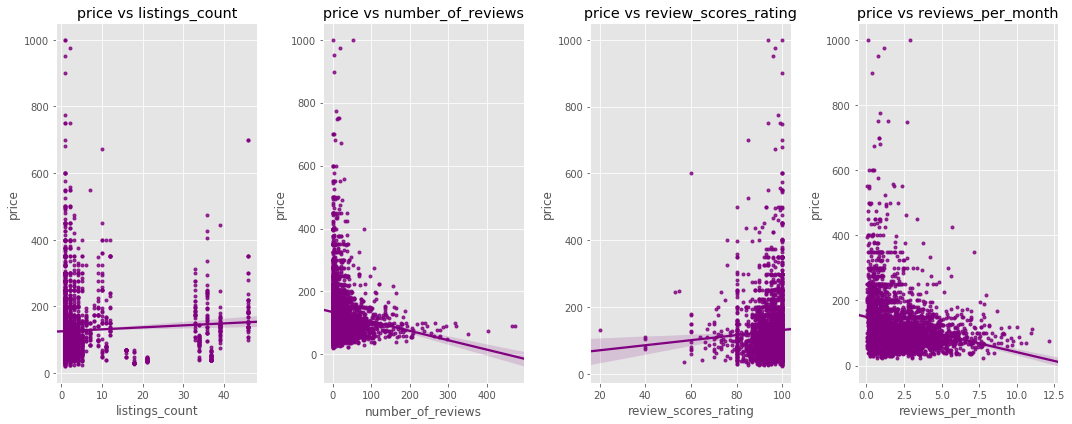

In [144]:
lst_pr = ['listings_count', 'number_of_reviews', 'review_scores_rating', 'reviews_per_month']
fig, ax = plt.subplots(1,3,figsize=(15,6))
for i in range(len(lst_pr)):
    plt.subplot(1,4,i+1)
    sns.regplot(x=lst_pr[i], y='price',data=num_listings,marker='.',color='purple');
    plt.title('price vs '+ lst_pr[i])
    plt.tight_layout()

Most of the listings (inclusive of high priced listings) have listings counts below 10  and concentrated  below 6.There are few listing owners with greater than 32  listings priced below 170$ and few above with one of them at above 600 dollars. There is marginal increase in the price when the listings count increase.

Listings below 200$ seems to affected by number of reviews and we also know that 75% of listings are priced below 155 dollars(price distribution histogram).As the number of reviews increase, the prices decrease.The increasing reviews are for listings below 170 dollars. There are also entries with 0 reviews.

Third plot shows neglible increase in price for increasing number of review score ratings.Concentration  of high ratings are for listings below 200$.The concentration of  review ratings are for reasonably priced listings from delighted customers.'Delighted' considering the  cluster of records of high valued ratings(80 and above).

Fourth plot shows  decrease in price for increasing reviews per month .Bulk of records are for below 7.5 reviews per month and then on pares down.There are also entries with 0 reviews per month. This plot is reflective of number of reviews plot. 

#### *Medium to Low priced listings have garnered higher reviews with mostly high review ratings. `75%` percentage of listings price fall in this category*

**Reviews and its impact.**

In [145]:
revw_col = [col for col in listings.columns.tolist() if 'review' in col]
revw_rating = listings[revw_col]
revw_rating['price']=num_listings['price']
revw_rating['host_is_superhost']=listings['host_is_superhost']

revw_rating.head(2)

,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,price,host_is_superhost
0,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,4.07,85.0,f
1,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,1.48,50.0,t


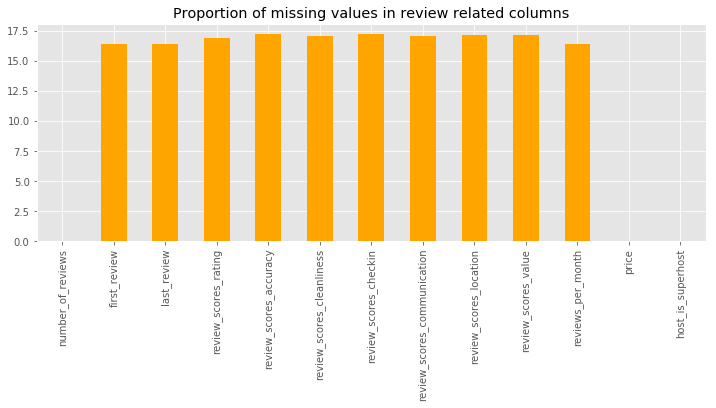

In [111]:
# Most of records are missing evenly
(revw_rating.isnull().sum(axis=0)/revw_rating.shape[0]*100).plot(kind='bar',figsize=(12,4),color='orange');
plt.title('Proportion of missing values in review related columns');

Looking closer
we can see the number of reviews is marked as 0 and corresponding review related columns are missing values Some of these lisings  are for superhosts.Records tagged as superhosts with no review values could be new listings from a superhost.One of the criteria for being a 'Superhost' is review rating(4.8+ overall rating) and it is missing values. Besides the overall rating,four other conditions needs to be met:10+ stays,0 cancellations,90% response rate and 50% review rate or higher.Superhost tag is assessed on quarterly basis and measured over the past 12 months. Response rate can be zero, so can the number of reviews (hence the missing values in review related columns).


One of the critera for being a 'Superhost', review rating is the aggregate of the below parameters. A Superhost is evaluated on these parameters -
    
    1. Cleanliness. Did the guests feel that the space was clean and tidy?
    2. Accuracy. How accurately did host's listing page represent the space?
    3. Value. Did the guest feel the listing provided good value for the price?
    4. Communication. How well did the host communicate with the guest before and during their stay?
    5. Check-in. How smoothly did their check-in go?
    6. Location. How did guests feel about the neighborhood?

In the following graph we see  superhost doing better in all the parameters.

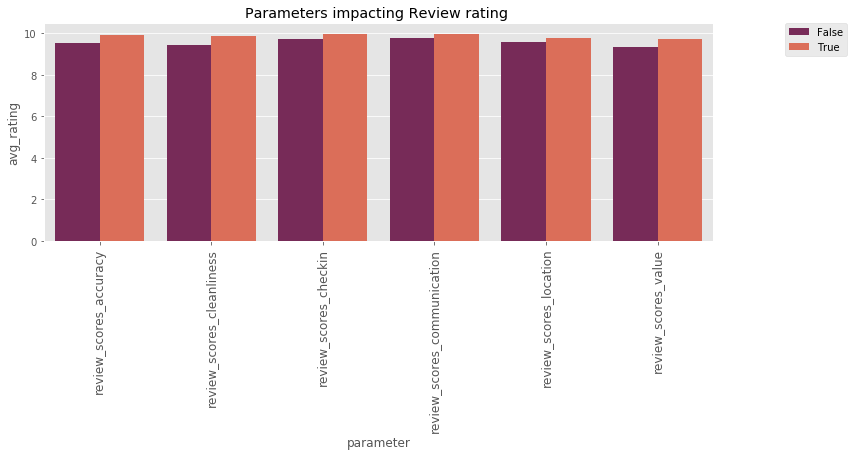

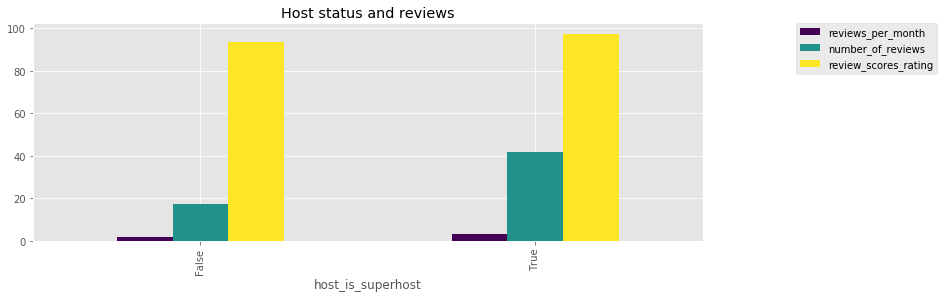

In [112]:
host_rvw = pd.melt(revw_rating,id_vars='host_is_superhost',value_vars=['review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value'],var_name='parameter',value_name='avg_rating')
fig = plt.subplots(figsize=(12,4))
ax = sns.barplot('parameter',y='avg_rating',data=host_rvw,hue='host_is_superhost',palette='rocket',ci=None)
plt.xticks(rotation=90,fontsize=12);
leg = plt.legend(bbox_to_anchor=(1.20, 1.0), loc=1, borderaxespad=0.);
leg.get_texts()[0].set_text('False');
leg.get_texts()[1].set_text('True');
plt.title('Parameters impacting Review rating ');

revw_rating.groupby('host_is_superhost')[['reviews_per_month','number_of_reviews','review_scores_rating']].mean().plot.bar(colormap='viridis',figsize=(12,4))
plt.xticks(np.arange(2),['False','True']);
plt.legend(bbox_to_anchor=(1.35, 1.0), loc=1, borderaxespad=0.);
plt.title('Host status and reviews');

Superhosts fare better in all the parameters,indicating better overall review rating for superhosts (closely followed by the non-superhosts).
Further analysis will be with review rating. The review parameter columns will be dropped.

Superhosts also recieve higher reviews per month, greater number of reviews and better review score rating.

**Drop the columns not part of further analysis.**

In [132]:
# Columns that can be dropped from num_listings dataframe
# review_scores_rating  and review_scores_values are correlated.Will keep review_scores_value.how abour other score values dependents?
# num_listings.drop(['reviews_per_month','review_scores_rating'])
# guests_included column is part of accomodates feature
num_listings.drop(['scrape_id','square_feet','license','review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value','guests_included'],axis=1,inplace=True )

In [133]:
# Remove columns that will not be used for our current analysis
# 'neighbourhood', --has nans 
# neighbourhood_cleansed - droping istead consider neighbourhood_cleansed group
# 'experiences_offered' - None values only
# 'neighborhood_overview','summary','space','description' - -needs text analysis
# has_availability -only true values
# host_verifications - has multiple entries for each record('email', 'phone', 'facebook', 'google', 'linkedin', 'reviews', 'jumio') - can check most popular verification modes
# 'email', 'phone', 'facebook', 'google', 'linkedin', 'reviews', 'jumio'
# host_location - has multiple locations.it is also a free text -NLP .
# Amenities will impact price - not considering for now, this does affect the pricing
col_dropped=[col for col in obj_listings.columns.tolist() if 'url' in col]+['name','host_verifications','has_availability','host_location','last_scraped','notes','weekly_price', 'monthly_price', 'security_deposit','neighbourhood','neighborhood_overview','summary','space','description','experiences_offered','transit','country','country_code','market','zipcode','smart_location','amenities',
                                                               'calendar_last_scraped','calendar_updated','first_review', 'last_review','requires_license', 'jurisdiction_names','state','host_about','host_response_time','host_name','cleaning_fee','extra_people','is_location_exact','street','host_neighbourhood','city','neighbourhood_cleansed','host_acceptance_rate']
obj_listings.drop(col_dropped,axis=1,inplace=True)

In [134]:
# convert host_since column to datetime object
obj_listings['host_since'] = pd.to_datetime(obj_listings['host_since'])

# Drop the price column from obj_listings
obj_listings.drop('price', axis=1, inplace=True) 

In [135]:
def conv_rate(col):
    '''
    replace '%' with ''
    ''' 
    col=col.str.replace('%','')
    return col

obj_listings['host_response_rate'] = conv_rate(obj_listings['host_response_rate']).astype('float64')

In [136]:
# Merge the numerical and categorical columns
abs_listings = num_listings.merge(obj_listings,on='id')
len(abs_listings.columns)

32

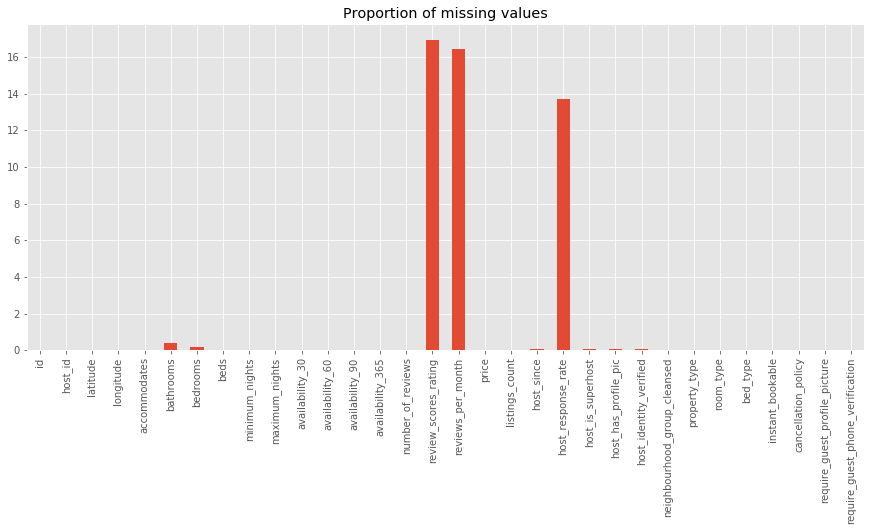

In [151]:
# Take a look at the proportion of missing values
((abs_listings.isnull().sum()/abs_listings.shape[0])*100).plot.bar(figsize=(15,6));
plt.title('Proportion of missing values');

**Evaluate missing row values**

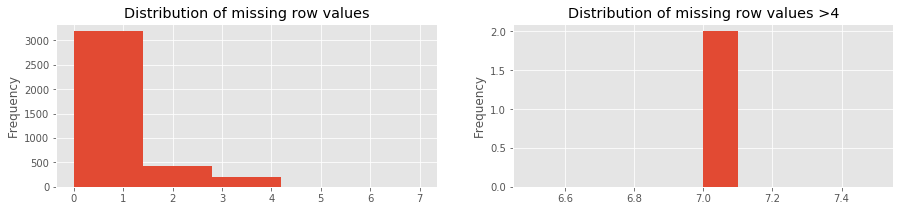

In [152]:
fig,ax = plt.subplots(figsize=(15, 3))
plt.subplot(1, 2, 1)
missing_rows = abs_listings.isnull().sum(axis=1)
missing_row_prop = missing_rows[missing_rows>0]/abs_listings.shape[1]*100
missing_rows.plot.hist(5)
plt.title('Distribution of missing row values');

plt.subplot(1, 2, 2)
sub_missing_row_prop = missing_rows[missing_rows>4]/abs_listings.shape[1]*100
missing_rows[missing_rows>4].plot.hist(10);
plt.title('Distribution of missing row values >4');

In [153]:
# With 4 as the missing row count threshold,split the dataframe into two
b_threshold = abs_listings[abs_listings.isnull().sum(axis=1)<=4].reset_index(drop=True)
a_threshold = abs_listings[abs_listings.isnull().sum(axis=1)>4].reset_index(drop=True)

In [154]:
print('%of data with no to few missing row values :{:.2f}'.format(b_threshold.shape[0]/abs_listings.shape[0]*100))
print('%of data with higher missing row values greater than threshold(4) :{:.2f}'.format(a_threshold.shape[0]/abs_listings.shape[0]*100))

%of data with no to few missing row values :99.95
%of data with higher missing row values greater than threshold(4) :0.05


Since the % of missing row values is very low we shall impute these values.For listings where number of reviews is 0,review related columns will be set to 0. 0 is a valid host_response_rate value.For non superhosts, the responses should be updated quickly and consistently to inquiries and reservation requests with in 24 hours in the past 30 days while the superhosts needs to maintain the response rate over the past 365 days else response rate continually drops.

In [137]:
# Set the null values to 0.The number of reviews is 0 and the review related columns also contain null values.host_response_rate can also be 0.
abs_listings['review_scores_rating']=abs_listings['review_scores_rating'].fillna(0)
abs_listings['host_response_rate']=abs_listings['host_response_rate'].fillna(0)
abs_listings['reviews_per_month']=abs_listings['reviews_per_month'].fillna(0)

In [138]:
# Use mode values to fill in the nans
abs_listings['bathrooms'].fillna(value=abs_listings['bathrooms'].mode()[0],inplace=True)
abs_listings['bedrooms'].fillna(value=abs_listings['bedrooms'].mode()[0],inplace=True)
abs_listings['beds'].fillna(value=abs_listings['beds'].mode()[0],inplace=True)

# One property value missing, fill with mode 
abs_listings['property_type'].fillna(value=abs_listings['property_type'].mode()[0],inplace=True)

# Two host_since entries missing.The urls to the listing doesnt return a valid entry.The 'nan' entry  will be filled with date 'last_scraped' on ie 2016-01-03.
abs_listings['host_since'].fillna(value='2016-01-03',inplace=True)
abs_listings['host_since']=pd.to_datetime(abs_listings['host_since'])

# Corresponding missing entries for 'host since' will be set to False('f')
abs_listings['host_is_superhost'].fillna(value='f',inplace=True)
abs_listings['host_has_profile_pic'].fillna(value='f',inplace=True)
abs_listings['host_identity_verified'].fillna(value='f',inplace=True)

In [139]:
# Check all nulls are dealt with
sum(abs_listings.isnull().sum())

0

In [140]:
# Save abs_listings dataframe as a .csv
abs_listings.to_csv('abs_listings_final.csv',index=False)

In [438]:
abs_listings_final=pd.read_csv('abs_listings_final.csv')

In [439]:
# Extract the year from hosted_since
abs_listings_final['host_since']=pd.to_datetime(abs_listings_final['host_since'])
abs_listings_final['hosted_yr']=abs_listings_final['host_since'].dt.year

**How has Seattle fared on the listing counts over the years?**

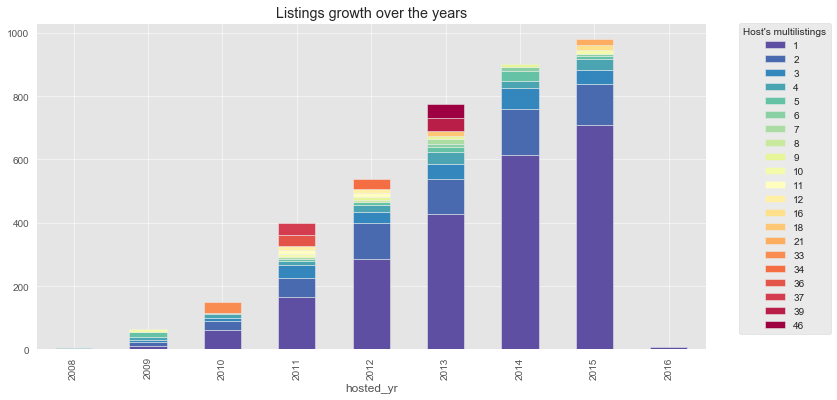

In [459]:
ax=abs_listings_final.groupby('hosted_yr')['listings_count'].value_counts().unstack().plot(kind='bar',colormap='Spectral_r',figsize=(12,6),stacked=True);
plt.legend(bbox_to_anchor=(1.05, 1.00), title= 'Host\'s multilistings',loc=2, borderaxespad=0.);

plt.title('Listings growth over the years')    ;

In [145]:
abs_listings_final['listings_count'].describe()

count    3818.000000
mean        4.276585
std         8.926239
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        46.000000
Name: listings_count, dtype: float64

The plot captures the phenomenal listings growth in Seattle from 2008 to 2015. Besides the overall growth,we see the growth of different multilistings. Since the data was scraped on 2016-01-04, only 4 days of data is available for January month of 2016 and we shall not consider it.  Nearly 75% of listings belongs to hosts who own maximum of 2 listings while median listing count owned is 1. Hosts with  1 and 2 listings have been growing consistently every year. Highest multiple listings goes to the host who has 46 listings.

2013 saw highest number of mulitple listings from hosts, with 46 being the highest multiple listings from a single host, followed by 39. Second mega multiple listings was in 2011,highest at 37 listings.


**Concentration of multiple listings**

What kind of multiple listings do we find in the neighbourhood groups? Is there any specific predominant listings type that is typical of a neighbourhood?

The host's listings will be categorized into bands: 'Low','Medium','High','V.High'  based on the range and interquartile range of the listings count feature. Here each band refers to the number of multiple listings owned by a host and hence the band they belong to. Below are the steps to achieve this categorization, and is followed by the resultant  graph.

In [147]:
#Summary Statistics
pd.Series(list((abs_listings_final['listings_count'].unique()))).describe()

count    21.000000
mean     17.047619
std      14.343905
min       1.000000
25%       6.000000
50%      11.000000
75%      33.000000
max      46.000000
dtype: float64

In [441]:
bins=[1,6,11,33,46]
labels=['Low','Medium','High','V.High']
abs_listings_final['listings_band']=pd.cut(abs_listings_final['listings_count'],bins=bins,labels=labels)

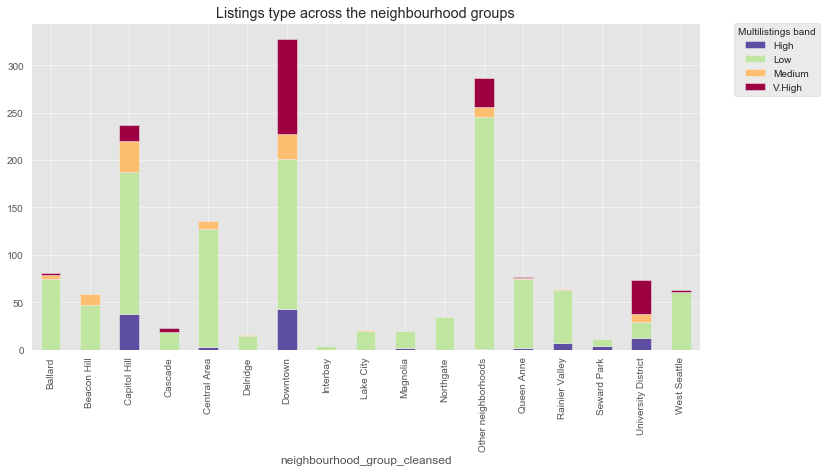

In [442]:
ax=abs_listings_final.groupby(['neighbourhood_group_cleansed'])['listings_band'].value_counts().unstack().plot(kind='bar',colormap='Spectral_r',figsize=(12,6),stacked=True);
plt.legend(bbox_to_anchor=(1.05, 1.00), title= 'Multilistings band',loc=2, borderaxespad=0.);

plt.title('Listings type across the neighbourhood groups')    ;

**Downtown**  tops the neighbourhood groups in terms of high count of multiple listings of high to very high bands from the host(s). Downtown is the central business district of Seattle - Serves as Seattle's finance and commercial maritime hub as well as its center of nightlife and shopping.Understandably we see high concentration of higher bands of multilistings.

Closely following Downtown we have, **University District, Capitol Hill and Other Neighborhood groups**. High count of higher multilistings is reflective  of high commercialization and these are centers of commerce and entertainment. A peek in to the neighborhoods offerings justifies that-

**Capitol Hill** is one of the city's most prominent nightlife and entertainment districts and is the center of the city's LGBT and counterculture communities.

**University District** - Being home to University of Washington has a thriving youth community and likely so has an eclectic mix of urban shopping areas; historic homes and architecture; and great cafes, pubs, restaurants, and theaters.

Likewise **Other Neighbourhood**  group is a collection of neighborhoods emanate a similar vibe. The streaks of Medium,High and V.High multilistings in the various neighborhoods share the features but are toned down.

**Northgate, Lake City,Interbay, Delridge** are comparatively laid-back and quieter neighborhoods.

####    *Dominant V.High and High  bands in a neighbourhood group is indicative of centres of trade and commerce.*


**How are the neighborhoods doing in terms of total listings and review rating?**

In [150]:
cln_ngbr_grpsub=abs_listings_final.groupby('neighbourhood_group_cleansed').agg({'review_scores_rating':'mean'})
cln_ngbr_grpsub_cnt=abs_listings_final['neighbourhood_group_cleansed'].value_counts()
cln_ngbr_grpsub_cnt=cln_ngbr_grpsub_cnt.to_frame().reset_index().rename(columns={'index':'neighbourhood_group_cleansed','neighbourhood_group_cleansed':'total_listings'}).set_index('neighbourhood_group_cleansed')
cln_ngbr_grps=cln_ngbr_grpsub_cnt.merge(cln_ngbr_grpsub,on='neighbourhood_group_cleansed')
cln_ngbr_grps=cln_ngbr_grps.reset_index().sort_values(by='total_listings')

In [427]:
cln_ngbr_grps['total_listings'].describe()

count     17.000000
mean     224.588235
std      220.448423
min       11.000000
25%       79.000000
50%      122.000000
75%      295.000000
max      794.000000
Name: total_listings, dtype: float64

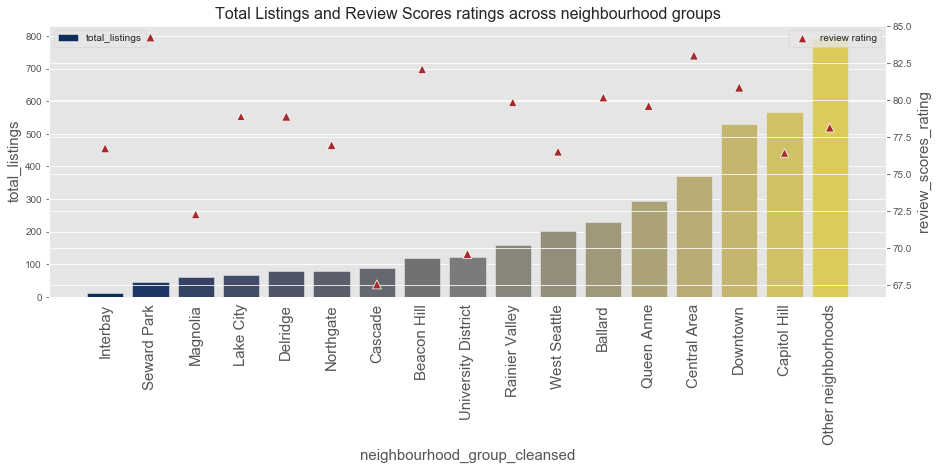

In [151]:
#ax1=ax.twinx()
#cln_ngbr_grpsub.plot.line(x='neighbourhood_cleansed', y='review_scores_value',ax=ax1, marker = 'o', linewidth = 0, rot = 45, label = 'Review scores', color = 'orange')
#plt.legend();
fig,ax=plt.subplots(figsize=(15,5))
s=[x for x in abs_listings_final.groupby('neighbourhood_group_cleansed')['review_scores_rating'].mean().values.tolist() ]
ax=sns.barplot(data=cln_ngbr_grps,x='neighbourhood_group_cleansed',y='total_listings',palette='cividis',label='total_listings')
plt.xticks(rotation=90,fontsize=15);
plt.xlabel('neighbourhood_group_cleansed',fontsize=15)
plt.ylabel('total_listings',fontsize=15)
plt.legend()

ax1=ax.twinx()
ax1=sns.scatterplot(x='neighbourhood_group_cleansed', y='review_scores_rating',data=cln_ngbr_grps,label='review rating',marker='^',s=s,color='brown')
plt.xlabel('neighbourhood_group_cleansed',fontsize=15)
plt.ylabel('review_scores_rating',fontsize=15)
#plt.legend(bbox_to_anchor=(0.90, 0.98), loc=1, borderaxespad=0.);
plt.title('Total Listings and Review Scores ratings across neighbourhood groups',fontsize=16);

'Other neighborhoods' neighbourhood group has the highest listings count and has above average review rating. The group is a colllection of 19 cleansed neighborhoods like Wallingford,Fremont,Crown Hall,Industrial District,etc 

Seward Park has the highest average review rating  followed by Central Area  and Beacon Hill.

Cascade has the lowest average review rating followed by University District and Magnolia.

Downtown being the central buisness district has second largest listings count and a good review ratings(above 80%).

#### *Majority of the neighborhood groups have  average to above average ratings  irrespective of the total listings. *

**How  does the price and review scores rating influence neighbourhood groups?**

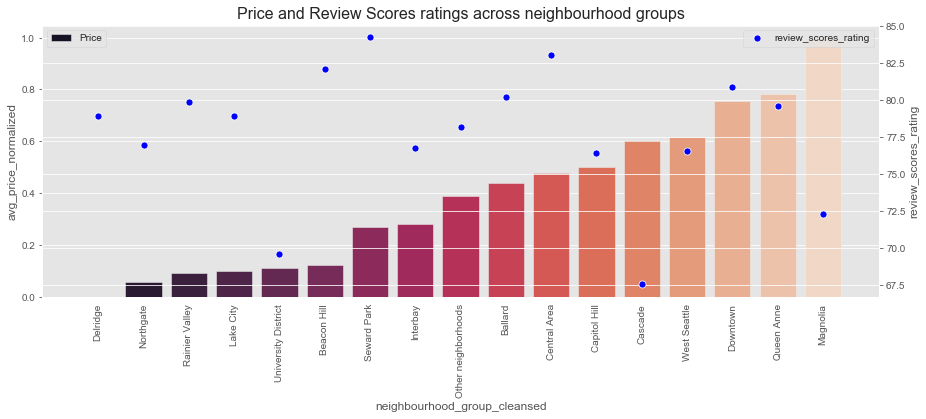

In [152]:
cln_ngbr_grp2=abs_listings_final.groupby('neighbourhood_group_cleansed').agg({'price':'mean','review_scores_rating':'mean'}).sort_values(by='price')
cln_ngbr_grp2=cln_ngbr_grp2.reset_index()
cln_ngbr_grp2=cln_ngbr_grp2.sort_values(by='price')
pr_min=cln_ngbr_grp2.price.min()
pr_max=cln_ngbr_grp2.price.max()
cln_ngbr_grp2['avg_price_normalized']=cln_ngbr_grp2['price'].apply(lambda x: (x - pr_min)/(pr_max - pr_min) )
#cln_ngbr_grp2['price_logtransformed']=cln_ngbr_grp2['price'].apply(np.log)


fig,ax=plt.subplots(figsize=(15,5))
ax=sns.barplot(data=cln_ngbr_grp2,x='neighbourhood_group_cleansed',y='avg_price_normalized',palette='rocket',label='Price')
plt.xticks(rotation=90);
plt.legend()
ax1=ax.twinx()
ax1=sns.scatterplot(x='neighbourhood_group_cleansed', y='review_scores_rating',data=cln_ngbr_grp2,label='review_scores_rating',marker='o',s=50,color='blue')
plt.legend();
plt.title('Price and Review Scores ratings across neighbourhood groups',fontsize=16);

The highest priced listings are in Magnolia but with a below average review rating and not exactly 'bang for the buck' rentals for the guests.

Queen Anne and Downtown seem to do better inspite of the pricier listings - Downtown being central buisness hub and Queen Anne, an affluent neighbourhood  and a popular spot for economic and cultural elite. 
Downtown also has the third highest listings in rentals to accommodate the floating population.

Comparing Cascade and West Seattle, though both are almost evenly priced, both are on the opposite ends of the ratings spectrum.

Beacon Hill is among lowered priced listings' neighbourhood group  but has high review ratings(above 80%).

Seward Park is moderately priced and has the best average review rating.

University District not only has low priced listings but also low review scores ratings.U-District has the highest concentration of multilistings(especially  in V.High multilistings ).This is one of the nighborhoods, popular with college students considering the main campus of the University of Washington (UW) is located here. Popularity with college students and low pricing could be enablers for owners to host many listings.

#### *Majority of the  lower and moderately  priced listings are rated  above  average.   Downtown and Queen Anne inspite of the pricier listings have above average ratings. *

*Let us drill down further to see how select neighborhoods have fared over the years.*

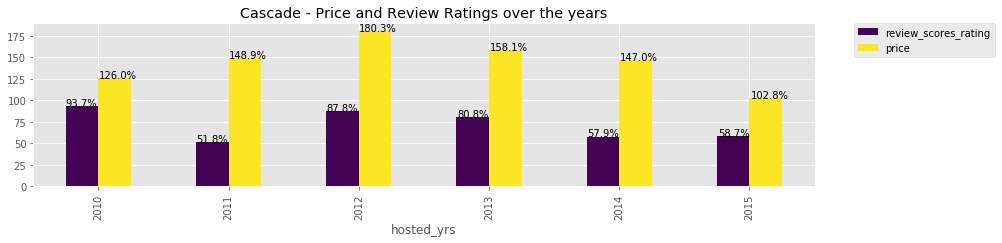

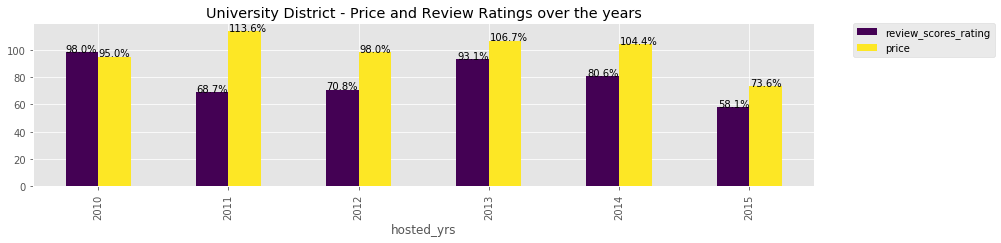

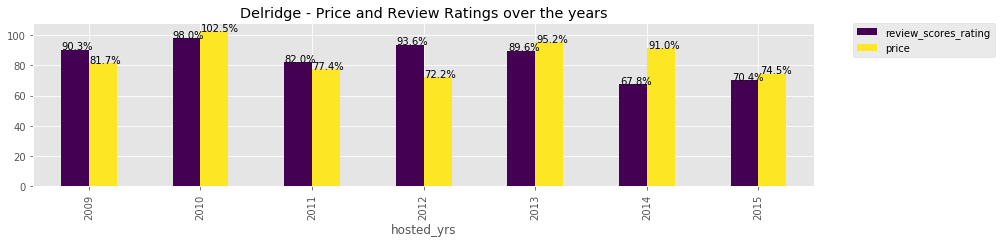

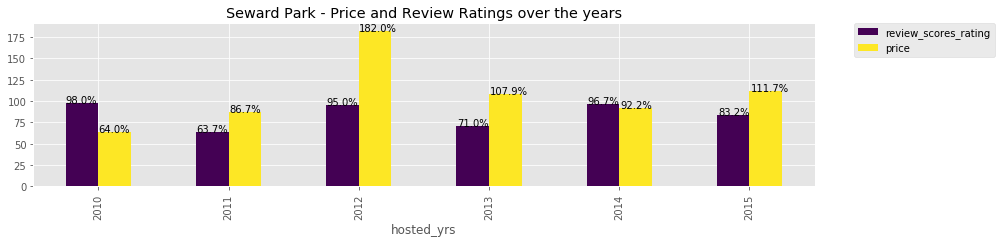

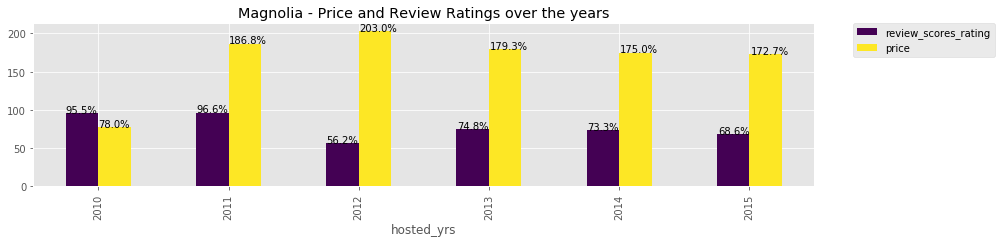

In [353]:
grp=['Cascade','University District','Delridge','Seward Park','Magnolia']

for loc in grp:
    fig, ax = plt.subplots()
    #ax2 = ax.twinx()
    abs_listings_final[abs_listings_final['neighbourhood_group_cleansed']==loc].groupby('hosted_yrs')[['review_scores_rating','price']].mean().plot(kind='bar',figsize=(14,3),colormap='viridis',ax=ax)
    #ax.legend(bbox_to_anchor=(1.05, 1.0), loc=2, borderaxespad=0.);
    #abs_listings[abs_listings['neighbourhood_group_cleansed']==loc].groupby('hosted_yr')[['listings_count']].mean().plot(kind='line',figsize=(14,3),color='b',ax=ax2)
    
    plt.title(loc +' - Price and Review Ratings over the years');
    
    plt.legend(bbox_to_anchor=(1.05, 1.00), loc=2, borderaxespad=0.);
    
    for p in ax.patches:
        ax.annotate('{:.1f}%'.format(p.get_height()), (p.get_x() * 1.002, p.get_height() * 1.0))

The initial year for all the selected neighbourhood groups have very good ratings.The listing prices for the neighborhoods saw a raise in the second year.
The trends for the individual neighbourhood groups :

**Cascade - ** Cascade,one of the above average priced listing had a drastic drop in the review rating compared to its initial year rating. Though the rating improved in 2012 to 87.8% from a previous 51.8%, ratings steadily declined along with the price peak in 2012 and stands lowest in 2015 and ratings % in 50's.
Cascade saw steady rise in pricing from 2010 to 2012 and subsequent steady downward fall but still on the higher side.

**University District - ** U-District in 2015 has the lowest listing price from all their prior years , the price declined by 29.5% from their previous year and also saw rating at 58.8%, a decline by 27.9% from the previous year and lowest since their previous years.

**Delridge - **  Delridge has maintained an above average to very good rating since 2009 at low listing price.The price variation is not drastic exception being 2010, the price had risen by 20.3% 

**Seward Park -** Seward Park has the highest average review rating with moderate pricing.The group saw the sharpest spike in pricing in 2012 about 52.36% increase from 2011's pricing, post which the price has declined.The group has an above average to very good rating.

**Magnolia - ** Magnolia , an affluent and second largest neighborhood of Seattle  by area is the most expensive of the neighbourhood groups. The listing price seems to have shot up  from 2011 onwards from a 78% to 186.8%    and has remained on the higher side.However much is desired from a ratings perspective.Only 2010 and 2011 saw very good ratings which have drasticallly reduced and maintained at just above average.

 

** Property availability for rent for all 365 days /year across neighborhoods in terms of listings count**

In [443]:
avail_365=abs_listings_final.groupby('neighbourhood_group_cleansed').agg({'availability_365':'mean','review_scores_rating':'mean','price':'mean'})
cln_ngbr_grpsub_cnt=abs_listings_final['neighbourhood_group_cleansed'].value_counts()
cln_ngbr_grpsub_cnt=cln_ngbr_grpsub_cnt.to_frame().reset_index().rename(columns=({'index':'neighbourhood_group_cleansed','neighbourhood_group_cleansed':'total_listings'})).set_index('neighbourhood_group_cleansed')
avail_365=avail_365.merge(cln_ngbr_grpsub_cnt,on='neighbourhood_group_cleansed')

In [444]:
#avail_365=abs_listings_final.groupby('neighbourhood_group_cleansed').agg({'total_listings':'mean','availability_365':'mean','review_scores_rating':'mean','price':'mean'})
avail_365['total_listings_normalized']=avail_365['total_listings']\
.apply(lambda x: (x - avail_365['total_listings'].min())/(avail_365['total_listings'].max() - avail_365['total_listings'].min()))
avail_365['availability_365_normalized']=avail_365['availability_365'].apply(lambda x: (x - avail_365['availability_365'].min())/(avail_365['availability_365'].max() - avail_365['availability_365'].min()))
avail_365['review_scores_rating_normalized']=avail_365['review_scores_rating'].apply(lambda x: (x - avail_365['review_scores_rating'].min())/(avail_365['review_scores_rating'].max() - avail_365['review_scores_rating'].min()))
avail_365['price_normalized']=avail_365['price'].apply(lambda x: (x - avail_365['price'].min())/(avail_365['price'].max() - avail_365['price'].min()))
avail_365.head(1)

,availability_365,review_scores_rating,price,total_listings,total_listings_normalized,availability_365_normalized,review_scores_rating_normalized,price_normalized
neighbourhood_group_cleansed,,,,,,,,
Ballard,252.673913,80.165217,124.682609,230,0.279693,0.431287,0.756751,0.438633


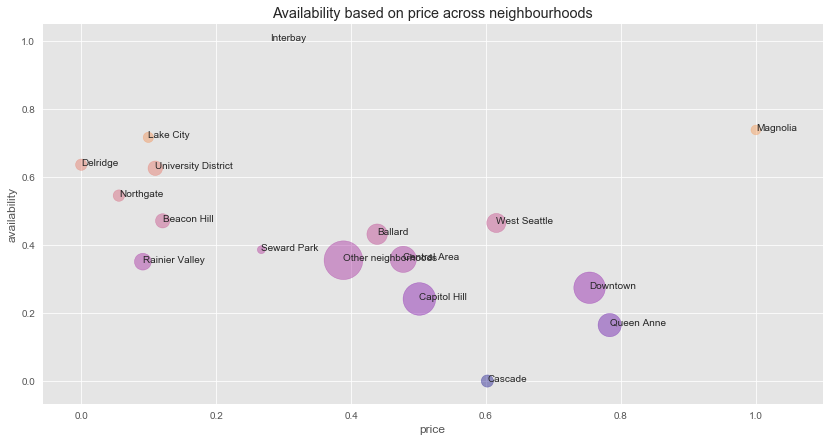

In [155]:
fig,ax=plt.subplots(figsize=(14,7))
ax.scatter(avail_365['price_normalized'],avail_365['availability_365_normalized'],c=avail_365['availability_365_normalized'],cmap='plasma',alpha=0.4,s=avail_365['total_listings_normalized']*1500)
plt.xlabel('price')
plt.ylabel('availability')
plt.xlim(right=1.1)
x=avail_365['price_normalized']
y=avail_365['availability_365_normalized']
plt.title('Availability based on price across neighborhoods')
for i, txt in enumerate(avail_365.index.tolist()):
    ax.annotate(txt, (avail_365['price_normalized'][i],avail_365['availability_365_normalized'][i]), fontsize = 10)      
#plt.subplots_adjust(right=1.5)    

The plot shows the listings available for rent, 365 days per year against listings price in the neighbourhood groups.

Low priced listings(0.0 - 0.2) have  about average(0.35 - 0.5) to above average(> 0.5) availability. These neighborhoods have low listings count.

Moderately priced listings(0.2 - 0.5) have just below average availability except Interbay.Interbay with moderate rating and moderate pricing has the highest availability. Interbay also has the least number of total listings. These neighborhoods have high listings count except Seward Park.

Most of above avg. priced listings(greater than 0.5) have average to below average availability except Magnolia.
These neighborhoods have high listings count except Cascade and Magnolia.

*Low priced and low listings count neighbourhood are clustered together (Cascade and Magnolia are exceptions) while moderate to higher priced listings  and high listings count neighbrhood groups are grouped together*

**Availability based on review ratings across neighborhoods**

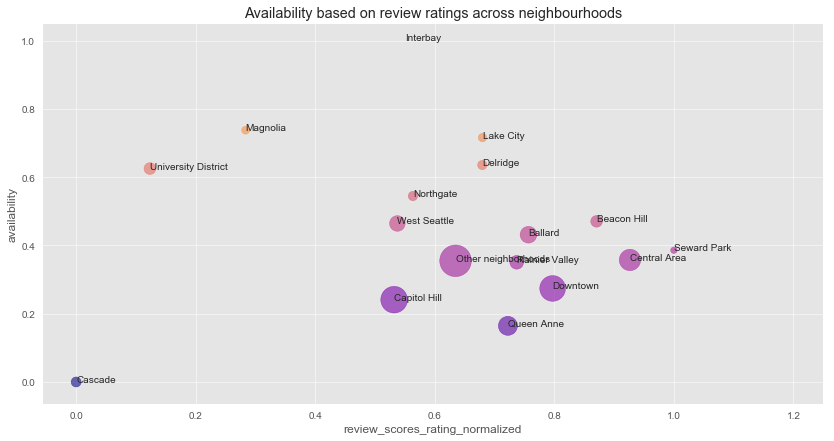

In [451]:
fig,ax=plt.subplots(figsize=(14,7))
ax.scatter(avail_365['review_scores_rating_normalized'],avail_365['availability_365_normalized'],c=avail_365['availability_365_normalized'],cmap='plasma',alpha=0.6,s=avail_365['total_listings_normalized']*1000)
plt.xlabel('review_scores_rating_normalized')
plt.ylabel('availability')
plt.xlim(right=1.25)

for i, txt in enumerate(avail_365.index.tolist()):
    ax.annotate(txt, (avail_365['review_scores_rating_normalized'][i],avail_365['availability_365_normalized'][i]), fontsize = 10);
    
plt.title('Availability based on review ratings across neighborhoods');    

The plot shows the listings available for rent for 365 days in a year(long term rental) against review scores rating in the neighbourhood groups.

neighborhoods with very good ratings(80% and above, eg. Seward Park,Central Area, Beacon Hill,etc) have average to below average availability. Listings here are priced moderately(average to just below average).

Cascade with lowest rating has the lowest availability while U-District and Magnolia have above average availabilty.
Interbay with moderate rating and moderate pricing has the highest availability.

Very expensive neighborhoods like Downton and Queen Anne,have above average rating and below average availability.

*The bulk of neighbourhoood groups with average to above average ratings have average to below average availabilty.If the plot were to be divided in to 4 quadrants, all of these would be in bottom right quadrant.
Most of the neighborhoods with higher listings count than others (except Seward Park) are clustered together.*

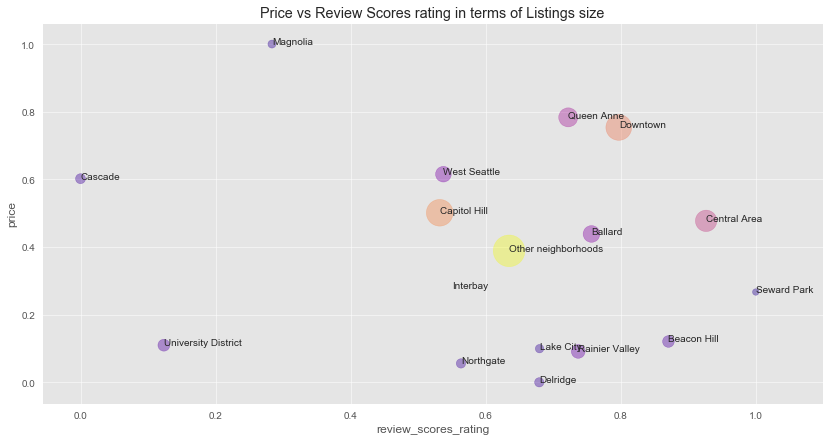

In [460]:
fig,ax=plt.subplots(figsize=(14,7))
ax.scatter(avail_365['review_scores_rating_normalized'],avail_365['price_normalized'],c=avail_365['total_listings_normalized'],cmap='plasma',alpha=0.4,s=avail_365['total_listings_normalized']*1000)
plt.xlabel('review_scores_rating')
plt.ylabel('price')
plt.xlim(right=1.1)
x=avail_365['review_scores_rating_normalized']
y=avail_365['price_normalized']

for i, txt in enumerate(avail_365.index.tolist()):
    ax.annotate(txt, (x[i],y[i]), fontsize = 10);
plt.title('Price vs Review Scores rating in terms of Listings size');

#plt.subplots_adjust(right=1.5) 

*Neighborhoods with above average ratings can be divided into low, medium and high priced .
Most of such low priced to moderate priced neighborhoods have small listing counts.High priced neighborhoods have bigger listing counts.*

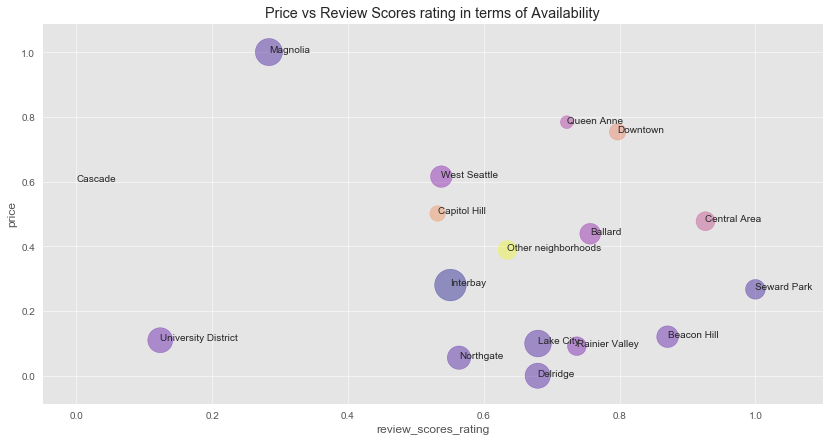

In [458]:
fig,ax=plt.subplots(figsize=(14,7))
ax.scatter(avail_365['review_scores_rating_normalized'],avail_365['price_normalized'],c=avail_365['total_listings_normalized'],cmap='plasma',alpha=0.4,s=avail_365['availability_365_normalized']*1000)
plt.xlabel('review_scores_rating')
plt.ylabel('price')
plt.xlim(right=1.1)
x=avail_365['review_scores_rating_normalized']
y=avail_365['price_normalized']

for i, txt in enumerate(avail_365.index.tolist()):
    ax.annotate(txt, (x[i],y[i]), fontsize = 10);
plt.title('Price vs Review Scores rating in terms of Availability');

#plt.subplots_adjust(right=1.5) 

*Neighborhoods with above average ratings can be divided into low, medium and high priced neighborhoods :
Availability is higher for all low to moderate listings compared to above medium priced neighborhoods.*

**Insight into calender data**

In [57]:
calender.head(2)

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00


In [156]:
# Convert date field to datetime object and extract month,day and year fields
calender['date'] = pd.to_datetime(calender['date'])
calender['month'] = calender['date'].dt.strftime('%b')
calender['day'] = calender['date'].dt.strftime('%a')
calender['year'] = calender['date'].dt.strftime('%Y')

In [157]:
# create dataframe with neighbourhood group and property type
ngrp_prop = abs_listings_final[['id', 'neighbourhood_group_cleansed', 'property_type']]   

#rename listing id to id to facilitate merging
calender.rename(columns = {'listing_id':'id'}, inplace=True)

#merge the dataframes on listing id
calender = calender.merge(ngrp_prop,on='id')

#ngrp_prop[ngrp_prop['id']==3335]#sample
calender['price'] = str_conv(calender['price'])

In [158]:
calender.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1393570 entries, 0 to 1393569
Data columns (total 9 columns):
id                              1393570 non-null int64
date                            1393570 non-null datetime64[ns]
available                       1393570 non-null object
price                           934542 non-null float64
month                           1393570 non-null object
day                             1393570 non-null object
year                            1393570 non-null object
neighbourhood_group_cleansed    1393570 non-null object
property_type                   1393570 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(6)
memory usage: 106.3+ MB


In [159]:
# Map availability values
calender['available'] = calender['available'].map({'t':True,'f':False })

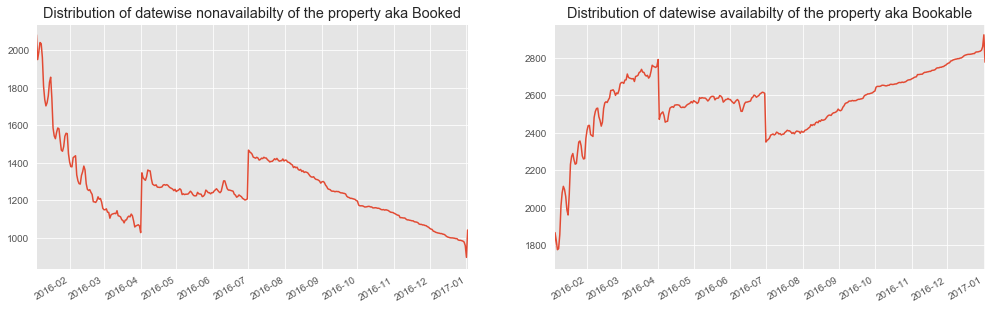

In [160]:
# Plot  availability of listings
fig,axes = plt.subplots(1,1,figsize=(17,5))
plt.subplot(1,2,1)

calender.query('available==False')['date'].value_counts().plot();
plt.title('Distribution of datewise nonavailabilty of the property aka Booked');

plt.subplot(1,2,2)
calender.query('available==True')['date'].value_counts().plot();
plt.title('Distribution of datewise availabilty of the property aka Bookable');

Let us see the availability or the lack of it on a daily basis.Refer the heatmap below.

In [19]:
#Ready the data
yrcal=calender[['date','available']].set_index('date')
del yrcal.index.name
del yrcal.columns.name

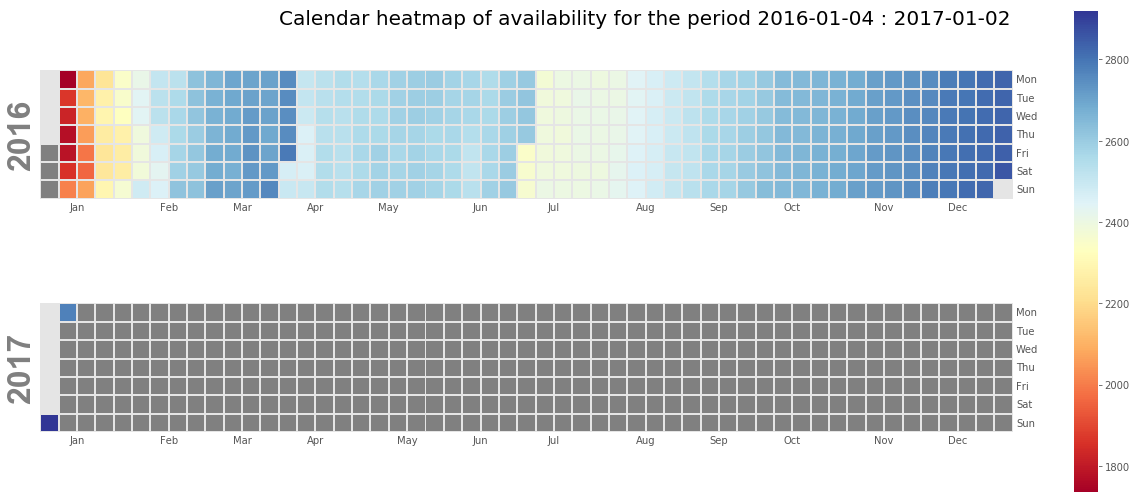

In [20]:
fig,ax=calmap.calendarplot(yrcal.available,
                    fillcolor='grey', linewidth=1,cmap='RdYlBu',
                    fig_kws=dict(figsize=(18,7)));

fig.colorbar(ax[0].get_children()[1], ax=ax.ravel().tolist());
fig.suptitle('Calendar heatmap of availability for the period 2016-01-04 : 2017-01-02' ,fontsize=20);

Rentals are least available in early January(upto second week) and becomes available in the days leading upto last weeks of December(most available).

From the least available second week of Jan gradually opens up and second most available slots in late March.The entire period starting from  April,May,Jun is moderatly booked only to become unavailable in late June to mid Jul as the second most non available period post which we see opening up of rentals pick up pace in 4th quarter especially in December.


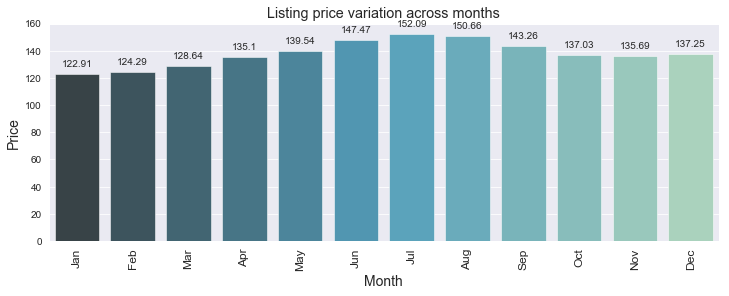

In [23]:
sns.set_style('darkgrid')
fig,ax=plt.subplots(1,1,figsize=(12,4))
sns.barplot(x='month',y='price',data=calender,ci=None,palette='GnBu_d')
plt.xticks(rotation=90,fontsize=12);
plt.xlabel('Month',fontsize=14)
plt.ylabel('Price',fontsize=14)
plt.title('Listing price variation across months')
for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points') 

Listing's prices are low in the first quarter peaking in Jul and declines slightly, with Nov having the lowest pricing of the last two quarters.

Looking at the calender heat map for availability or the lack of it, July sees reduced availabilty and maximum pricing.
As the months progress listings are made available, and there is a gradual  fall in the pricing. Progressing towards the end of December availability is maximum,price is on the higher side only to fall in the January with least availability.The period from May to September is pricey peaking in July.April and 3rd quarter are moderately pricey.

March being the most affordable as availability is second highest after December.


In [161]:
def quarter(col):
    '''
    Group months under  four quarters
    
    Parameters:
    col(Series object) - Object with month names
    
    Returns:
    col(Series object) - new column categorizing a month to a specific quarter.
    
    '''
    if col in ['Jan','Feb','Mar']:
        return 'Q1'
    elif col in ['Apr','May','Jun']:
        return 'Q2'
    elif col in ['Jul','Aug','Sep']:
        return 'Q3'
    else:
        return 'Q4'
    
calender['quarter']=calender['month'].apply(quarter)

In [162]:
def prop_catg(col):
    '''
    Categorize property types under three types
    
    Parameters:
    col(Series object) - Object with property type
    
    Returns:
    col(Series object) - new column categorizing a property to a specific property category.
    '''
    if col in ['Apartment']:
        return 'Apartment'
    elif col in ['House']:
        return 'House'
    else:
        return 'Other'
calender['prop_catg']=calender['property_type'].apply(prop_catg)   

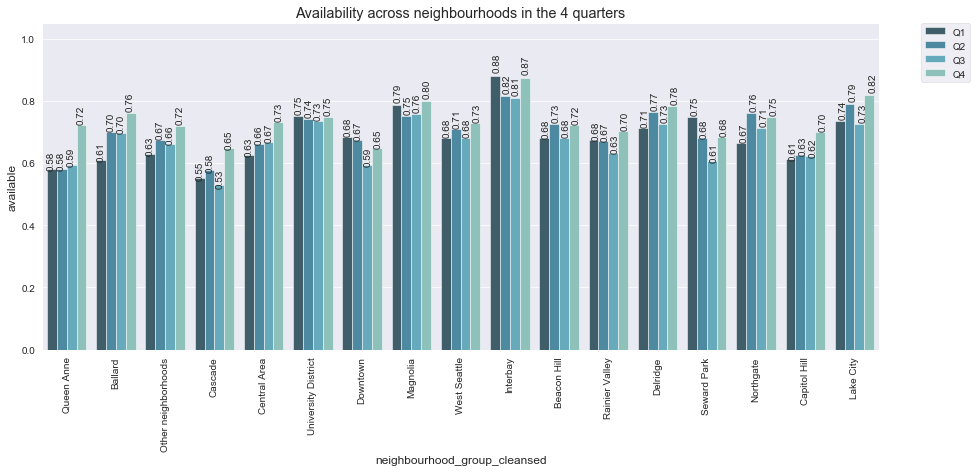

In [23]:
sns.set_style('darkgrid')
fig,axes=plt.subplots(1,1,figsize=(15,6))
sns.barplot(x='neighbourhood_group_cleansed',y='available',data=calender,hue='quarter',ci=None,palette='GnBu_d')
plt.xticks(rotation=90);
plt.ylim(top=1.05)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc=2, borderaxespad=0.);
plt.title('Availability across neighborhoods in the 4 quarters')

for p in axes.patches:
    axes.annotate('{:.2f}'.format(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.06),rotation=90)
#fig.subplots_adjust(top=1.5)   

Availability in the last quarter is the maximum in most of the neighbourhood groups with few exceptions viz.

1. Seward Park ,Interbay,Downtown and U-District have highest availability in the first quarter.
2. University District is the only neighbourhood which doesnt seem to have much fluctuation in the four quarters compared to other neighbourhood groups with maximum (75%) availabilty in the 1st and 4th quarter.74% in the 2nd and least in 3rd quarter with 73% availability.
3. Northgate and Beacon Hill have highest availability in the 2nd quarter.

In [163]:
# Fill the Nans with 0.
calender['price'] = calender['price'].fillna(0)

# Normalise the price
#calender['price_normalized']=calender['price'].apply(lambda x: (x - calender['price'].min())/(calender['price'].max() - calender['price'].min()))

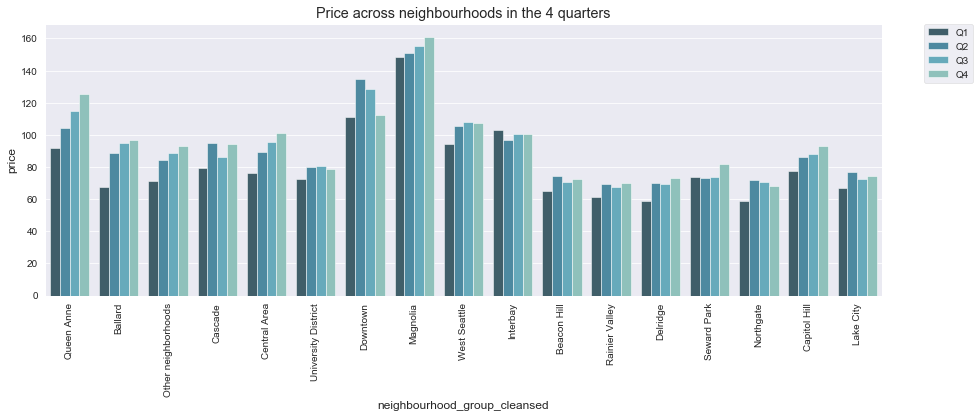

In [164]:
sns.set_style('darkgrid')
fig,axes=plt.subplots(1,1,figsize=(15,5))
sns.barplot(x='neighbourhood_group_cleansed',y='price',data=calender,hue='quarter',ci=None,palette='GnBu_d')
plt.xticks(rotation=90);
plt.title('Price across neighborhoods in the 4 quarters')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc=2, borderaxespad=0.);

In the previous graph we saw availability is highest in the last quarter in most neighborhoods,likewise we see price is maximum in last quarter for most neighborhoods.

Lets consider a select set of neighborhoods - 

**Seward Park** - With highest availability in the first quarter and gradual dip through to the third quarter and a subsequent raise in availability equal to second quarter sees an almost flat pricing in the first three quarters and increases moderately only in the 4th quarter.Good review rating, availability((1st,2nd and 4th quarter ) and moderate pricing sounds like an attractive rental prospect. 

**Downtown **- A central buisness district with expensive pricing and above average review rating has highest availability in first quarter and declines through to the 3rd quarter.The 4th quarter has availability little below 2nd quarter.First and fourth quarter seems attractive in terms of pricing.

** University District** - With maximum availability in 1st and 4th quarter, pricing is lowest in 1st and lower in 4th quarters compared to 2nd and 3rd quarter.

**Beacon Hill and North Gate** - Northgate and Beacon Hill have highest availability in the 2nd quarter and the pricing is also highest in the second quarter. 4th quarter availability and 4th quarter pricing is a good combination for a rental.

Lets look at the daily price changes in the calender heatmap below for select neighbourhood groups.

In [165]:
# Ready the data ,Seward Park,Downtown,University District
yrcalp=calender[calender['neighbourhood_group_cleansed']=='Seward Park'][['date','price']].set_index('date')
del yrcalp.index.name
del yrcalp.columns.name

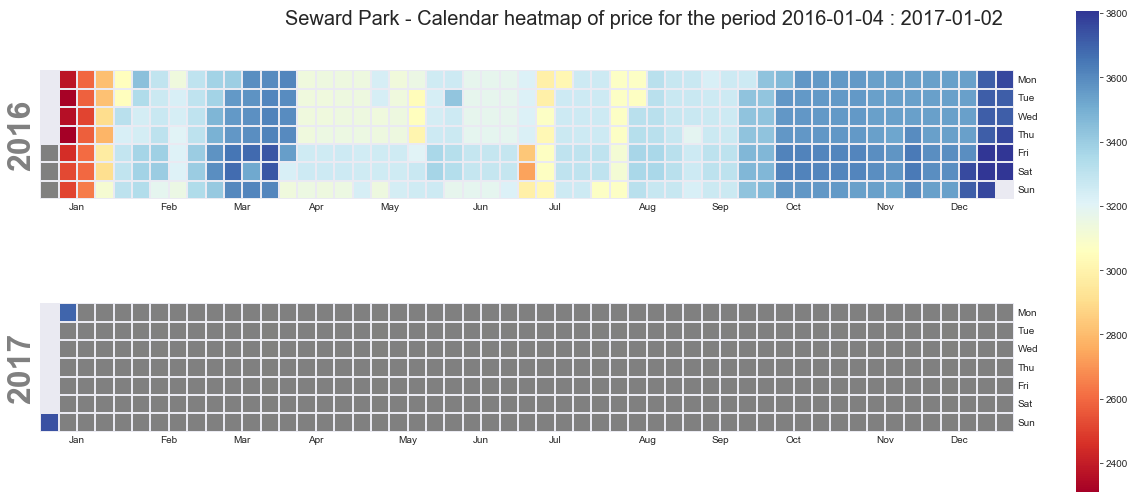

In [166]:
fig,ax=calmap.calendarplot(yrcalp.price,
                    fillcolor='grey', linewidth=1,cmap='RdYlBu',
                    fig_kws=dict(figsize=(18,7)));

fig.colorbar(ax[0].get_children()[1], ax=ax.ravel().tolist());
fig.suptitle('Seward Park - Calendar heatmap of price for the period 2016-01-04 : 2017-01-02' ,fontsize=20);

Other than the extremes of Jan and Dec price variation,Seward Park sees price variation (lower side) in Feb,Apr to early Sep.

Lowest price being in the first week of January and mild price rise in the subsequent weeks. Price peaks in the 3rd week of March especially on Friday and Saturday only to drop in April.As we look through the days, fridays and Saturdays are slightly higher priced. Looks like there is a discount in late Jun (Friday and Saturday). There is a smattering of low priced days in third week of May,late June,early July and late July. Price picks up progressively from then on only to peak in the last two weeks of December.

The price variation from April to first half of September is small and on a lower side considering the overall price variation(across neighborhood groups) across months, for the same period.

*Considering that the 3rd quarter has least availability, first(barring Mar) and second quarter is a good time to rent.*

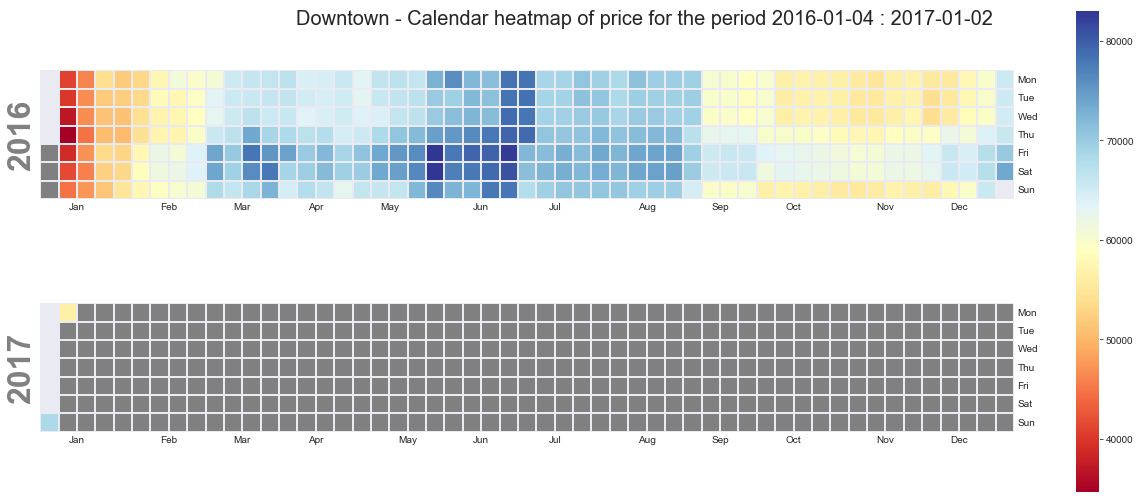

In [28]:
yrcalpD=calender[calender['neighbourhood_group_cleansed']=='Downtown'][['date','price']].set_index('date')
del yrcalpD.index.name
del yrcalpD.columns.name

fig,ax=calmap.calendarplot(yrcalpD.price,
                    fillcolor='grey', linewidth=1,cmap='RdYlBu',
                    fig_kws=dict(figsize=(18,7)));

fig.colorbar(ax[0].get_children()[1], ax=ax.ravel().tolist());
fig.suptitle('Downtown - Calendar heatmap of price for the period 2016-01-04 : 2017-01-02' ,fontsize=20);

Pricing strategy is different here. We saw overall price peak in July and flanked by higher but slightly lower price in June and August. Here  we see price peak in June, Fridays and Saturdays in May and on few days (esp.Friday and Saturday) in March. September to mid December has a moderate pricing and a increase towards final  week of December. 

Lowest pricing is in early Jan and highest in late June and in friday and Saturday of Late May.Feb,Sep,Oct,Nov,part Dec has rentals at nearly half price.

Downtown has the lowest availabilty in 3rd quarter and opens up slightly in the 4th quarter.Highest availabilty in first and followed by second quarter.

*Times that would be lighter on the pocket would be first quarter,early second quarter,late third quarter and early 4th quarter. Fridays and Saturdays tend to have higher price compared to the rest of the days* 

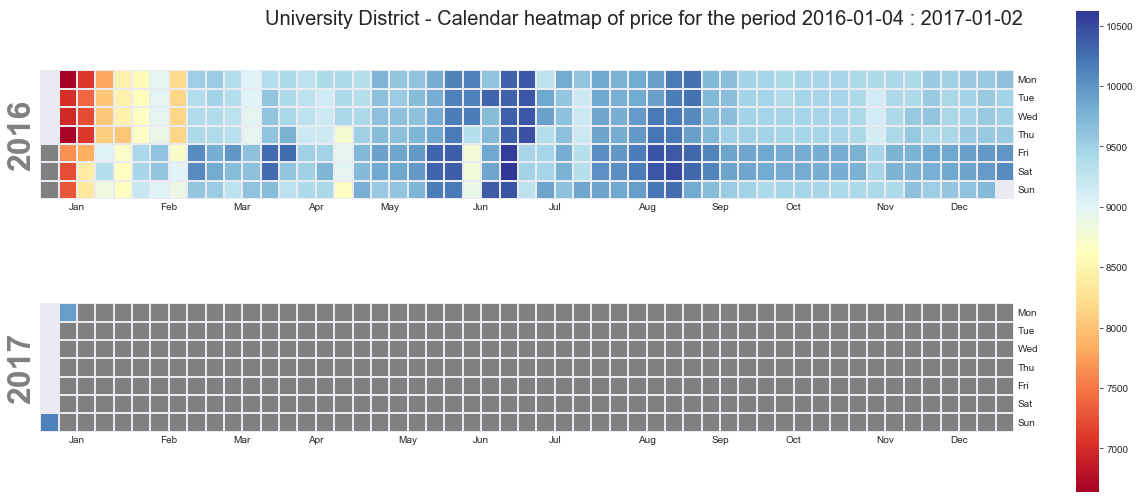

In [29]:
yrcalpU=calender[calender['neighbourhood_group_cleansed']=='University District'][['date','price']].set_index('date')
del yrcalpU.index.name
del yrcalpU.columns.name

fig,ax=calmap.calendarplot(yrcalpU.price,
                    fillcolor='grey', linewidth=1,cmap='RdYlBu',
                    fig_kws=dict(figsize=(18,7)));

fig.colorbar(ax[0].get_children()[1], ax=ax.ravel().tolist());
fig.suptitle('University District - Calendar heatmap of price for the period 2016-01-04 : 2017-01-02' ,fontsize=20);

University District has second lowest rating with low priced listings.

Though the overall pricing is low, almost all of the months show above average pricing with price peaking in June and August.
Early January sees lowest pricing along with few lower priced days in February,April and June.Rest of the days across months is clearly above average.
Peak pricing seen on Fridays and Saturdays in late February, mid March, mid June and August.

*U District has max availability in 1st and last quarter.Pricing is best in first quarter. Last quarter is a little above average priced.All of Fridays and Saturdays is relatively costly.*

In [167]:
# Before modelling, lets look at the datatypes for any pending trasnformations
abs_listings_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 34 columns):
id                                  3818 non-null int64
host_id                             3818 non-null int64
latitude                            3818 non-null float64
longitude                           3818 non-null float64
accommodates                        3818 non-null int64
bathrooms                           3818 non-null float64
bedrooms                            3818 non-null float64
beds                                3818 non-null float64
minimum_nights                      3818 non-null int64
maximum_nights                      3818 non-null int64
availability_30                     3818 non-null int64
availability_60                     3818 non-null int64
availability_90                     3818 non-null int64
availability_365                    3818 non-null int64
number_of_reviews                   3818 non-null int64
review_scores_rating                3818 no

Convert Object type features to binary

In [169]:
ncol_to_conv=['host_is_superhost','host_has_profile_pic','host_identity_verified','require_guest_profile_picture','instant_bookable','require_guest_phone_verification']
map_val=lambda x: 0 if x =='f' else 1
abs_listings_final[ncol_to_conv] = abs_listings_final[ncol_to_conv].applymap(map_val)

One hot encoding of the categoricals

In [170]:
abs_listings_final=pd.get_dummies(abs_listings_final,columns=['listings_band','neighbourhood_group_cleansed','property_type','room_type','bed_type','cancellation_policy'])

In [171]:
# Save the model ready dataset
abs_listings_final.to_csv('abs_listings_model.csv',index=False,encoding='utf-8')

In [331]:
# Read the dataset
abs_listings_model=pd.read_csv('abs_listings_model.csv')

In [332]:
abs_listings_model.head(2)

,id,host_id,latitude,longitude,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,...,room_type_Private room,room_type_Shared room,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict
0,241032,956883,47.636289,-122.371025,4,1.0,1.0,1.0,1,365,...,0,0,0,0,0,0,1,0,1,0
1,9167786,956883,47.642358,-122.374047,2,1.0,1.0,1.0,1,1125,...,1,0,0,0,0,0,1,1,0,0


In [347]:
abs_listings_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 69 columns):
id                                                  3818 non-null float64
host_id                                             3818 non-null float64
accommodates                                        3818 non-null float64
bathrooms                                           3818 non-null float64
bedrooms                                            3818 non-null float64
beds                                                3818 non-null float64
minimum_nights                                      3818 non-null float64
maximum_nights                                      3818 non-null float64
availability_30                                     3818 non-null float64
availability_60                                     3818 non-null float64
availability_90                                     3818 non-null float64
availability_365                                    3818 non-null float64
numbe

In [334]:
# Drop the columns
abs_listings_model=abs_listings_model.drop(['latitude', 'longitude','host_since','listings_band_Low','listings_band_Medium','listings_band_High','listings_band_V.High'],axis=1)

In [335]:
# the data is highly skewed, apply log transformation
abs_listings_model['price']=abs_listings_model['price'].apply(lambda x: np.log(x))

In [336]:
# Initialize scaler, then apply it to the numeric features
scaler = MinMaxScaler() # default=(0, 1)
numeric = ['id', 'host_id', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'minimum_nights', 'maximum_nights', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'review_scores_rating', 'reviews_per_month',
       'listings_count', 'host_response_rate','price','hosted_yr']

In [337]:
#Create a copy of the main df
abs_listings_scaled=pd.DataFrame(data=abs_listings_model)

#Apply Scaler transformation
#https://stats.stackexchange.com/questions/29781/when-conducting-multiple-regression-when-should-you-center-your-predictor-varia

abs_listings_scaled[numeric]=scaler.fit_transform(abs_listings_model[numeric])

In [366]:
#Ready the explanatory  and target data
X=abs_listings_scaled.copy(deep=True)
X.drop(['price'], axis=1, inplace=True)

y=abs_listings_scaled['price']

# Split the 'features' and 'label' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 2)

## Data  Modeling


Following algorithms will be evaluated for performance to determine the best that best models the data  -
Linear regression,Lasso Regression, Random forest and  XGBoost.

### Application of Linear Regression

In [368]:
# Instantiate the model
lr = LinearRegression()

# fit the model
lr.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

#### Evaluate the model

In [369]:
# Apply predict on train data
pred_train=lr.predict(X_train)

# Score the model
score = r2_score(y_train,pred_train)

# Find Root Mean Squared Error
RMSE = np.sqrt(metrics.mean_squared_error(y_train,pred_train))

print('R Squared score for Linear regression model on test data:%f' %(score))
print('RMSE for Linear regression model on test data:%f' %(RMSE))

R Squared score for Linear regression model on test data:0.688434
RMSE for Linear regression model on test data:0.081351


In [387]:
# Apply predict on test data
pred_test=lr.predict(X_test)

# Score the model on test data 
# score=lr.score(X_test,y_test)
r2score=r2_score(y_test,pred_test)

RMSE = np.sqrt(metrics.mean_squared_error(y_test,pred_test))

print('R Squared score for Linear regression model on test data:%f' %(r2score))
print('RMSE for Linear regression model on test data:%f' %(RMSE))

R Squared score for Linear regression model on test data:0.694518
RMSE for Linear regression model on test data:0.078318


The linear regression model accounts for the 69.45% of variance,ie R squared value or the coefficent of multiple determiniation. We want the RMSE  values to be as small as possible,indicating how close the observed values are to the predicted values,0.078 is a good value.  

Below is the feature importance plot for linear regression model. 

In [389]:
len(lr.coef_)

68

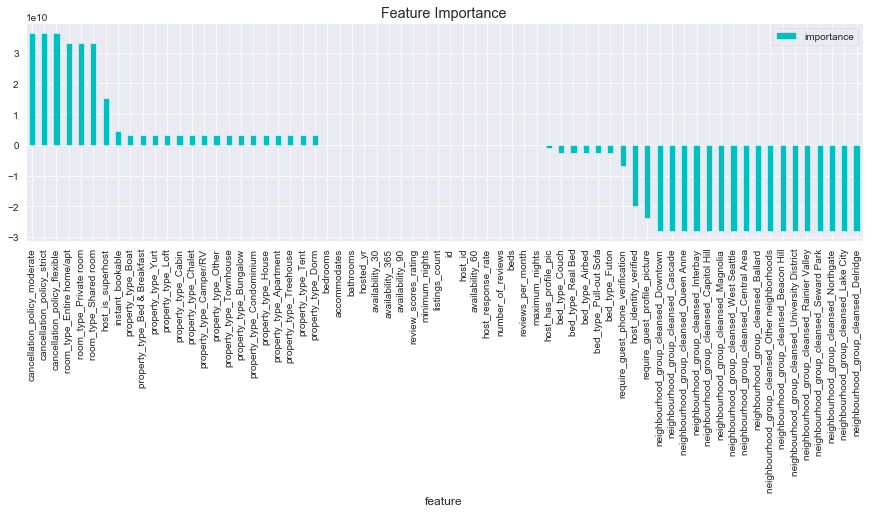

In [393]:
#Features and its weight
lr_features=pd.DataFrame({'feature':X_train.columns[:len(lr.coef_)],'importance':lr.coef_})

#feature importance
lr_features.sort_values(by='importance',ascending=False).set_index('feature').plot.bar(figsize=(15,4),color='c');
plt.title('Feature Importance');

Cancellation policy and room type are strong positive influencers on price.There are also multiple features influencing negatively.Lets check the validity of the model using the residual plot.

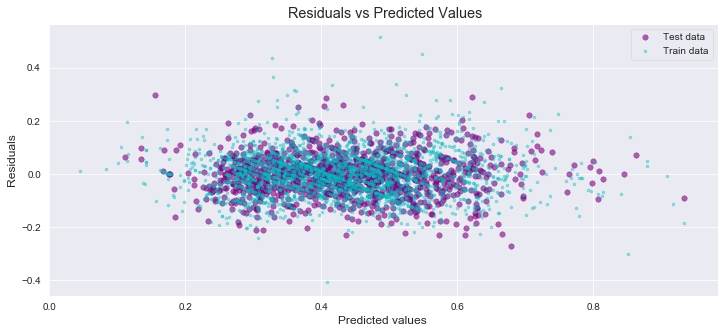

In [394]:
#Residual plot
fig,ax=plt.subplots(figsize=(12,5))
plt.scatter(pred_test,  y_test - pred_test,
            c='purple', marker='o', label='Test data',alpha=0.6,s=30)
plt.scatter(pred_train,  y_train - pred_train,
            c='c', marker='.', label='Train data',alpha=0.4)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='bottom right')
plt.title(' Residuals vs Predicted Values');

Residuals should be random like in our example (ie the errors should not have a pattern) indicative of the appropriateness of the linear regression model. 

Residuals are randomly scattered around zero and tending to cluster around zero ie forming a horizontal band around 0 suggesting  variances of the error terms are similar across values of independent variables.

The residuals on zero are those which are predicted correctly. The data points on residual = 0  corresponds to estimated regression line.

Now let us check if  tuning linear regression using regularization technique helps simplify the model and improve the regression metrics.

### Lasso Regression

In [406]:
from sklearn.linear_model import Lasso

lssoReg = Lasso(alpha=0.0001,normalize=True,random_state=0, max_iter=10000)

#Fit the model
lssoReg.fit(X_train,y_train)

Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=True, positive=False, precompute=False, random_state=0,
      selection='cyclic', tol=0.0001, warm_start=False)

In [407]:
# Apply predict on train data
pred_ls_train=lssoReg.predict(X_train)

# Score the model
score = r2_score(y_train,pred_ls_train)

# Find Root Mean Squared Error
RMSE = np.sqrt(metrics.mean_squared_error(y_train,pred_ls_train))

print('R Squared score for Lasso regression model on train data:%f' %(score))
print('RMSE for Lasso regression model on train data:%f' %(RMSE))

R Squared score for Lasso regression model on train data:0.654676
RMSE for Lasso regression model on train data:0.085644


In [408]:
# Apply predict on test data
pred_ls_test=lssoReg.predict(X_test)

# Score the model
score = r2_score(y_test,pred_ls_test)

# Find Root Mean Squared Error
RMSE = np.sqrt(metrics.mean_squared_error(y_test,pred_ls_test))

print('R Squared score for Lasso regression model on test data:%f' %(score))
print('RMSE for Lasso regression model on test data:%f' %(RMSE))

R Squared score for Lasso regression model on test data:0.669385
RMSE for Lasso regression model on test data:0.081476


Both R squared score and RMSE are lower compared to linear regression metrics for test data.

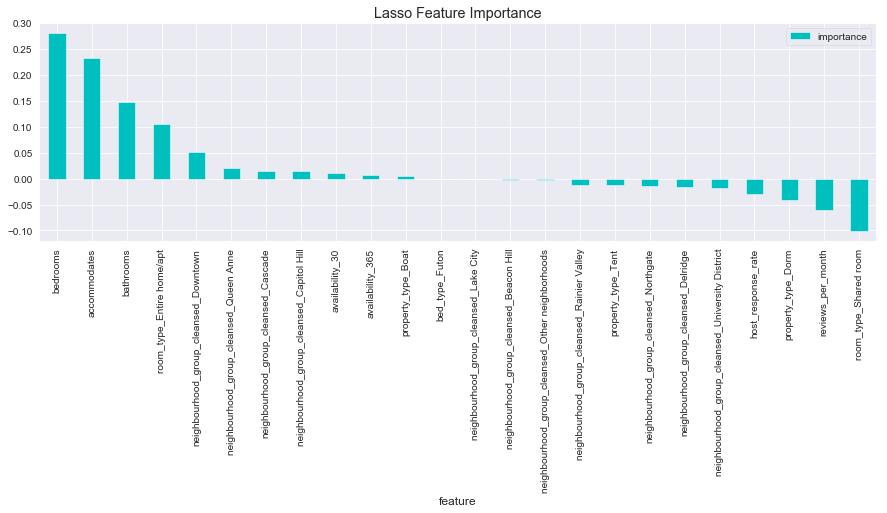

In [401]:
#Features and its weight
lsso_features=pd.DataFrame({'feature':X_train.columns,'importance':lssoReg.coef_})

#feature importance
lsso_features[lsso_features.importance!=0].sort_values(by='importance',ascending=False).set_index('feature').plot.bar(figsize=(15,4),color='c');
plt.title('Lasso Feature Importance');


Bedrooms feature is the most positively influencing feature on price while room type shared room is the most negatively influencing feature on price.

**Cross Validation Lasso **

In [409]:
lassocv = LassoCV(cv=5, max_iter=10000, normalize=True,random_state=0)
lassocv.fit(X_train, y_train)  
lssoReg.set_params(alpha=lassocv.alpha_)
lssoReg.fit(X_train, y_train)
pred_cv_ls = lssoReg.predict(X_test)


# Score the model
score = r2_score(y_test,pred_cv_ls)

# Find Root Mean Squared Error
RMSE = np.sqrt(metrics.mean_squared_error(y_test,pred_cv_ls))

print('Alpha:%f' %(lassocv.alpha_))
print('R Squared score for Lasso regression model on cross validation:%f' %(score))
print('RMSE for Lasso regression model on cross validation:%f' %(RMSE))


Alpha:0.000032
R Squared score for Lasso regression model on cross validation:0.694383
RMSE for Lasso regression model on cross validation:0.078336


** Lasso regresson metrics are better than the test data and same as  Linear regression metrics.**

###  Application of Random forest Regressor

In [360]:
# Create the pipeline
rf = make_pipeline(RandomForestRegressor(random_state=2))

# Fit the model
rf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('randomforestregressor',
                 RandomForestRegressor(bootstrap=True, criterion='mse',
                                       max_depth=None, max_features='auto',
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=10, n_jobs=None,
                                       oob_score=False, random_state=2,
                                       verbose=0, warm_start=False))],
         verbose=False)

#### Evaluate the model

In [361]:
# Evaluate train data 
pred_train = rf.predict(X_train)

print("R2Score: " +str( r2_score(y_train,pred_train)))
RMSE = np.sqrt(metrics.mean_squared_error(y_train,pred_train))
print("RMSE: " + str(RMSE)) 

R2Score: 0.9414004143765866
RMSE: 0.03528029635883505


In [362]:
#Evaluate test data
pred_test = rf.predict(X_test)

print("R2Score: " +str( r2_score(y_test,pred_test)))

RMSE = np.sqrt(metrics.mean_squared_error(y_test,pred_test))
print("RMSE: " + str(RMSE)) 

R2Score: 0.6623725644524718
RMSE: 0.08233588846320025


In [420]:
# Top 10 features affecting response variable
top_features =rf.steps[0][1].feature_importances_
feature_importances = pd.DataFrame({"feature":X.columns.values, "importance":top_features})
feature_importances.sort_values("importance", ascending=False)[:10]

,feature,importance
57,room_type_Entire home/apt,0.258962
4,bedrooms,0.222409
3,bathrooms,0.093078
0,id,0.035519
14,reviews_per_month,0.034833
2,accommodates,0.033618
1,host_id,0.032574
11,availability_365,0.026431
10,availability_90,0.021856
16,host_response_rate,0.021356


### [Hyperparameter tuning]( https://stats.stackexchange.com/questions/160479/practical-hyperparameter-optimization-random-vs-grid-search)

####  Randomized Search with Cross Validation

In [364]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 5)]
# Number of features to consider at every split
max_features = ['sqrt','auto']
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid. Use the random grid to search for best hyperparameters
random_grid = {'randomforestregressor__n_estimators': n_estimators,
               'randomforestregressor__max_features': max_features,
               'randomforestregressor__min_samples_split': min_samples_split,
               'randomforestregressor__min_samples_leaf': min_samples_leaf,
               'randomforestregressor__bootstrap': bootstrap}



In [365]:
# Random search of parameters, using 3 fold cross validation, search across 150 different combinations
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 50, cv = 3, verbose=2,
                               random_state = 0, n_jobs = -1, 
                               scoring = 'neg_mean_squared_error')
# Fit our model
rf_random.fit(X_train, y_train)

rf_random.best_params_

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  7.8min finished


{'randomforestregressor__bootstrap': False,
 'randomforestregressor__max_features': 'sqrt',
 'randomforestregressor__min_samples_leaf': 1,
 'randomforestregressor__min_samples_split': 2,
 'randomforestregressor__n_estimators': 550}

#### Grid Search with Cross Validation

In [236]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'randomforestregressor__bootstrap': [False],
    'randomforestregressor__max_features': ['sqrt'],
    'randomforestregressor__min_samples_leaf': [1,2],
    'randomforestregressor__min_samples_split': [2,3],
    'randomforestregressor__n_estimators': [550,570] 
}

In [237]:
# Instantiate the grid search model with param_grid from the Random Search
grid_search = GridSearchCV(estimator = rf, 
                           param_grid = param_grid, 
                           cv = 4, n_jobs = -1, verbose = 2, 
                           scoring = 'neg_mean_squared_error')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

grid_search.best_params_

Fitting 4 folds for each of 8 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:   56.5s finished


{'randomforestregressor__bootstrap': False,
 'randomforestregressor__max_features': 'sqrt',
 'randomforestregressor__min_samples_leaf': 1,
 'randomforestregressor__min_samples_split': 2,
 'randomforestregressor__n_estimators': 570}

In [307]:
# Create the pipeline 
rf_grid = make_pipeline(RandomForestRegressor(random_state=0,
                                                            bootstrap = False,
                                                            max_features = 'sqrt',                                                            
                                                            min_samples_leaf = 1,
                                                            min_samples_split = 2,
                                                            n_estimators = 570))

# Fit the model
rf_grid.fit(X_train, y_train)

predictions_rf = rf_grid.predict(X_test)

#evaluate
r2score=round(r2_score(y_test,predictions_rf),2)
RMSE = np.sqrt(metrics.mean_squared_error(y_test,predictions_rf))
print("R Squared Score: " + str(r2score ))
print("Root Mean Square Error: " + str(RMSE))

R Squared Score: 0.72
Root Mean Square Error: 0.07556054674143631


In [308]:
# Evaluate on test data
predictions_rf_grid_te = rf_grid.predict(X_test)

print("R Squared score: " + str(round(r2_score(y_test,predictions_rf_grid_te), 2)))
RMSE = np.sqrt(metrics.mean_squared_error(y_test,predictions_rf_grid_te))
print("RMSE: " + str(RMSE)) 

R Squared score: 0.72
RMSE: 0.07556054674143631


**Both R squared and RMSE values have improved in Random Forest regression.**

###  Application of   XGBRegressor

In [239]:
# conda install -c anaconda py-xgboost
# Create the pipeline: 
xgb = make_pipeline(XGBRegressor(random_state = 2))

# Fit the model
xgb.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bytree=1, gamma=0,
                              learning_rate=0.1, max_delta_step=0, max_depth=3,
                              min_child_weight=1, missing=None,
                              n_estimators=100, n_jobs=1, nthread=None,
                              objective='reg:linear', random_state=2,
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                              seed=None, silent=True, subsample=1))],
         verbose=False)

In [240]:
## Evalute on test data
pred_xgb_te = xgb.predict(X_test)
print("R Squared score: " + str(round(r2_score(y_test,pred_xgb_te), 2)))

RMSE = np.sqrt(metrics.mean_squared_error(y_test,pred_xgb_te))
print("RMSE: " + str(RMSE))

R Squared score: 0.73
RMSE: 0.07411908892609687


In [241]:
# Evalute on train data
pred_xgb_tr = xgb.predict(X_train)
print("R Squared score: " + str(round(r2_score(y_train,pred_xgb_tr), 2)))

RMSE = np.sqrt(metrics.mean_squared_error(y_train,pred_xgb_tr))
print("RMSE: " + str(RMSE)) 

R Squared score: 0.77
RMSE: 0.07016128305180679


In [242]:
xgb.get_params()

{'memory': None,
 'steps': [('xgbregressor',
   XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
                max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
                n_jobs=1, nthread=None, objective='reg:linear', random_state=2,
                reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                silent=True, subsample=1))],
 'verbose': False,
 'xgbregressor': XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=1, nthread=None, objective='reg:linear', random_state=2,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=True, subsample=1),
 'xgbregressor__base_score': 0.5,
 'xgbregressor__booster': 'gbtree'

#### Random Search with cross validation

In [243]:
params = {'xgbregressor__learning_rate': [0.1, 0.05],
          'xgbregressor__max_depth': [2,3,4],
          'xgbregressor__n_estimators': [100, 300],
          'xgbregressor__colsample_bytree': [0.7, 0.3]}

rmsearchxgb = RandomizedSearchCV(xgb, param_distributions=params, 
                            random_state=0, n_iter=300, 
                            cv=3, verbose=1, n_jobs=-1, return_train_score=True)

rmsearchxgb.fit(X_train, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   21.8s finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('xgbregressor',
                                              XGBRegressor(base_score=0.5,
                                                           booster='gbtree',
                                                           colsample_bylevel=1,
                                                           colsample_bytree=1,
                                                           gamma=0,
                                                           learning_rate=0.1,
                                                           max_delta_step=0,
                                                           max_depth=3,
                                                           min_child_weight=1,
                                                           missing=None,
                                                           n_estimators

In [244]:
rmsearchxgb.best_params_

{'xgbregressor__colsample_bytree': 0.7,
 'xgbregressor__learning_rate': 0.1,
 'xgbregressor__max_depth': 3,
 'xgbregressor__n_estimators': 300}

#### Grid Search with CV

In [414]:
param_grid = {'xgbregressor__learning_rate': [0.1, 0.05], 
              'xgbregressor__max_depth': [3,4,5 ],
              'xgbregressor__n_estimators': [300, 500],
             'xgbregressor__colsample_bytree': [0.7, 0.3]}

# Instantiate the grid search model
grid_searchxgb = GridSearchCV(estimator = xgb,
                           param_grid = param_grid, 
                           cv = 3, n_jobs = -1, verbose = 2, 
                           scoring = 'neg_mean_absolute_error')

# Fit the grid search to the data
grid_searchxgb.fit(X_train, y_train)

grid_searchxgb.best_params_


Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   34.9s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   54.1s finished


{'xgbregressor__colsample_bytree': 0.3,
 'xgbregressor__learning_rate': 0.05,
 'xgbregressor__max_depth': 4,
 'xgbregressor__n_estimators': 500}

#### Fit the model

In [417]:
# Create the pipeline:
xgb_grid = make_pipeline(XGBRegressor(random_state = 2,
                                      ##learning_rate = 0.05
                                      ##max_depth = 5,
                                      ##n_estimators = 1000,
                                      colsample_bytree=0.3,
                                      learning_rate = .05,
                                      max_depth = 4,
                                      n_estimators = 500
                                     ))

# Fit the model
xgb_grid.fit(X_train, y_train)

# Evaluate on train data
predictions_xgb_tr = xgb_grid.predict(X_train)

print("R Squared score: " + str(round(r2_score(y_train,predictions_xgb_tr), 2)))
RMSE = np.sqrt(metrics.mean_squared_error(y_train,predictions_xgb_tr))
print("RMSE: " + str(RMSE)) 


R Squared score: 0.87
RMSE: 0.05351794902135937


In [418]:
# Evaluate on test data
predictions_xgb_te = xgb_grid.predict(X_test)

print("R Squared score: " + str(round(r2_score(y_test,predictions_xgb_te), 2)))
RMSE = np.sqrt(metrics.mean_squared_error(y_test,predictions_xgb_te))
print("RMSE: " + str(RMSE)) 

R Squared score: 0.75
RMSE: 0.07153717962993228


R Squared and RMSE values have improved significantly and is the best of all of four models tested.

Below is the visualization of the regression metrics on the models trained.

### Model selection on Goodness-of-Fit Statistics 

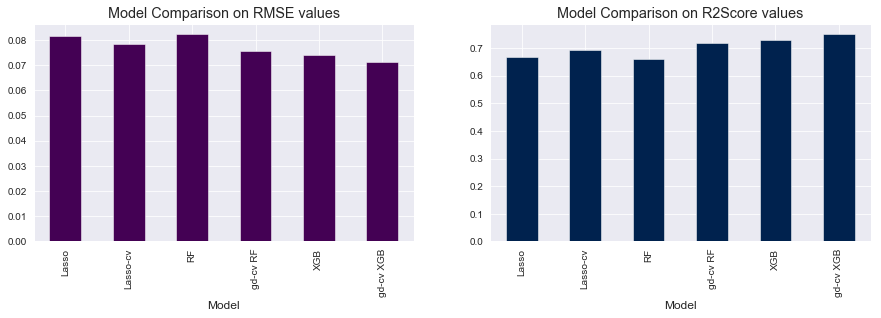

In [421]:
metric_val = pd.DataFrame({'RMSE':[ 0.08147, 0.0783, 0.0823, 0.0755, 0.0741, 0.0715],'R2score':[0.669385, 0.694383, 0.6623, 0.72, 0.73, 0.75],'Model':['Lasso','Lasso-cv','RF','gd-cv RF','XGB','gd-cv XGB']},index=[0,1,2,3,4,5])
fig,ax=plt.subplots(1,2,figsize=(15,4))
plt.subplot(1,2,1)
metric_val.set_index('Model')['RMSE'].plot.bar(colormap='viridis');
plt.title('Model Comparison on RMSE values');

plt.subplot(1,2,2)
metric_val.set_index('Model')['R2score'].plot.bar(colormap='cividis')
plt.title('Model Comparison on R2Score values');

Tuned Xtreme Gradient Booster has performed best among the models,in terms of reduced error and improved R squared score.

**Top features that can guide feature selection**

Feature importance based on weight - number of times a feature occurs in the trees of the model

In [461]:
top_features =xgb_grid.steps[0][1].feature_importances_
feature_importances = pd.DataFrame({"feature":X.columns.values, "importance":top_features})
feature_importances.sort_values("importance", ascending=False)[:10]

,feature,importance
0,id,0.101360
1,host_id,0.073857
14,reviews_per_month,0.069685
12,number_of_reviews,0.054543
11,availability_365,0.052070
2,accommodates,0.047899
7,maximum_nights,0.041409
15,listings_count,0.039555
13,review_scores_rating,0.037392
10,availability_90,0.034765


**Plot feature importance**

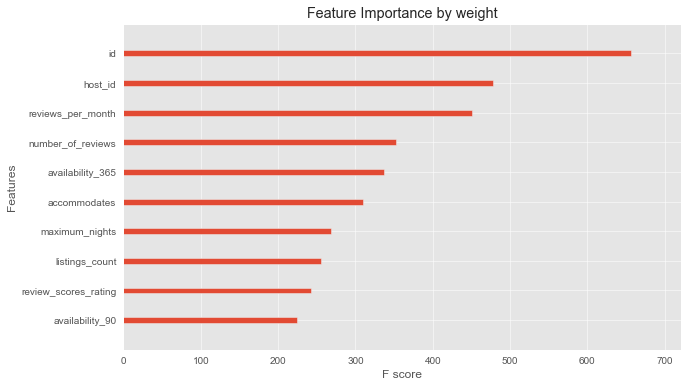

In [464]:
d=xgb_grid.steps[0][1]._Booster.get_score(importance_type='weight')
plt.rcParams["figure.figsize"] = (10, 6)
plot_importance(d,show_values=False,max_num_features =10);
plt.title('Feature Importance by weight');

Feature importance based on gain - measure of the contribution of the corresponding feature to the model calculated by considering each feature's contribution to each tree of the model.

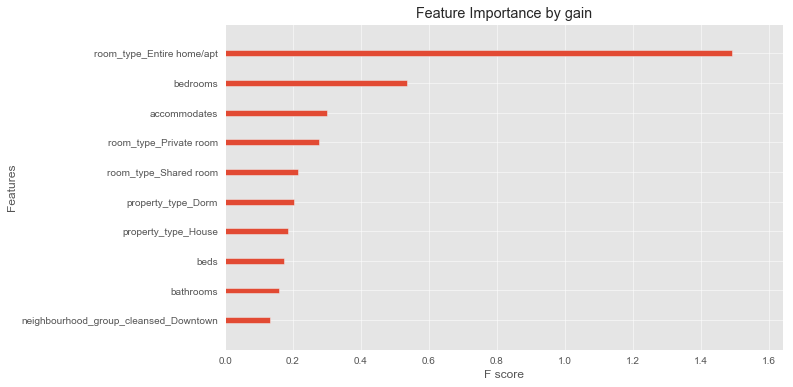

In [465]:
d=xgb_grid.steps[0][1]._Booster.get_score(importance_type='gain')
plt.rcParams["figure.figsize"] = (10, 6)
plot_importance(d,show_values=False,max_num_features =10);
plt.title('Feature Importance by gain');

In [424]:
#Top features with their information gain 
pd.DataFrame(dict(itertools.islice(d.items(), 69)),index=range(1)).T.rename(columns={0:'Gain'}).sort_values(ascending=False,by='Gain').head(10)

,Gain
room_type_Entire home/apt,1.493413
bedrooms,0.534314
accommodates,0.300541
room_type_Private room,0.275811
room_type_Shared room,0.213690
property_type_Dorm,0.204007
property_type_House,0.186662
beds,0.174687
bathrooms,0.159035
neighbourhood_group_cleansed_Downtown,0.133374


These are the top 10 features which contributed the most to each tree of the model.

### Limitations

1. Multicollinearity has not been looked in the linear regression model.
2. Feature Selection and its methods has not been dealt with.
3. All the files have not been considered.For eg. reviews.csv. Text analysis is required for further data minining and build a stronger model.
4. There is scope for image processing via the urls of the pictures uploaded by the host,etc

### Conclusion

*Summarizing the findings from the analysis and modeling, we have the following inferences:*

1. Medium to Low priced listings have garnered higher reviews with mostly high review ratings. 75% percentage of listings price fall in this category.

2. Superhosts fare better in all the parameters,indicating better overall review rating for superhosts.Superhosts also recieve higher reviews per month, greater number of reviews and better review score rating. 

3. Concentration of High and V.High band of multilistings is indicative of centers of trade and commerce.

4. Property availability for rent for all 365 days /year across neighborhoods in terms of listings count and Availability based on review ratings across neighborhoods
  - The bulk of neighbourhoood groups with average to above average ratings have average to below average availabilty -the pricing of these listings vary from low to high with more moderately priced listings.
  - Least availability is in the first two weeks of Jan.Gradually opens up till March.Post March slightly drops till early Aug and then gradually opens up till Dec end.

5. In terms of pricing first quarter is least expensive and gradually builds and peaks in July and declines till November and picks up in December.November and April pricing is more or less same. March ,October and November times are good times to book rentals. This is an overall availability and pricing across listings. One still needs to consider neighborhood group of interest to review the availability and pricing.

6. Comparing the data models,Lasso Regression, Random Forest and XGBooster,tuned XGBooster performed best in terms of R2score and RMSE value of 0.75 and .071 respectively. Tuned XGBooster model is able explain 75% of the total variance in the response variable. RMSE value of 0.071 indicates how close the observed data points are to the model's predicted values.


*Objectives addressed:*

1. Listings growth over the years in various neighborhoods of Seattle.
    For the time frame,2008 to 2015 Seattle has had pheonominal listings growth. Besides the overall growth,we see the growth of different multilistings. Nearly 75% of listings belongs to hosts who own maximum of 2 listings while median listing count owned is 1. Hosts with 1 and 2 listings have been growing consistently every year. Highest multiple listings goes to the host who has 46 listings.

2. Concentration of multiple listings in the neighbourhood groups and their impact.
Dominant V.High and High bands in a neighbourhood group is indicative of centres of trade and commerce. Downtown, University district,Capitol Hill and Other Neighbourhood groups have high concentration of high and very high multilistings.
 
3. Identify neighborhoods :Popular and Distinct neighborhoods in terms of pricing and ratings.
Majority of the lower and moderately priced neighborhoods are rated above average. In spite of the pricier listings, Downtown and Queen Anne have above average ratings. Seward Park has the highest rating and is moderately placed and also have low listings counts.

4. Times of the year,where we see availability at best pricings - March being the most affordable as availability is second highest after December. That being said, one needs to look at the specific neighbourhood's pricing strategy for the calender year for a clearer picture.

5. Top features that influence the pricing are -
  room_type_Entire home/apt, bedrooms, accommodates, room_type_Private room, room_type_Shared room, id, host id, reviews_per_month, number_of_reviewavailability_365


## Deployment

Prior to deploying the model to production, the data mining process and the model evaluation reults are presented to the buisness stakeholders to review and take action. Business insights from the data analysis and modeling is presented as a [blog](https://medium.com/@kusumsanand/insight-into-seattle-neighborhoods-6f552998ce55)